# folders

In [ ]:
cd /content

/content


In [ ]:
!mkdir architecture_search

In [ ]:
cd /content/architecture_search

/content/architecture_search


In [ ]:
!mkdir custom_layers

In [ ]:
!mkdir models

In [ ]:
!mkdir preprocessing

In [ ]:
!mkdir trainer

# custom_layers

In [ ]:
cd /content/architecture_search/custom_layers

/content/architecture_search/custom_layers


In [ ]:
%%writefile __init__.py


Writing __init__.py


In [ ]:
%%writefile auto_layers.py

import tensorflow as tf


from tensorflow.python.framework import tensor_shape
from tensorflow.python.eager import context
from tensorflow.python.framework import common_shapes
from tensorflow.python.framework import ops
from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
# from tensorflow.python.keras.engine.base_layer import InputSpec
from keras.engine.input_spec import InputSpec
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.keras.utils import generic_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import sparse_ops
from tensorflow.python.ops import standard_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.ops import variables as tf_variables
from tensorflow.python.util.tf_export import tf_export

from tensorflow.keras.layers import Conv2D, Layer

from utils import max_dil, prune_mul, binarize, g_weights

import sys

class Dilation_Reg(tf.keras.regularizers.Regularizer):

    def __init__(self, reg_strength, c_in, c_out, r_f, l2=0.05):
        self.reg_strength = reg_strength
        self.c_in = c_in
        self.c_out = c_out
        self.r_f = r_f
        self.l2 = l2

    def __call__(self, w):
        gamma_weights = g_weights(w, self.c_in, self.c_out, self.r_f)
        return self.reg_strength * tf.reduce_sum(
            tf.multiply(
                    gamma_weights,
                    tf.abs(w),
                    )
            ) + self.l2 * tf.reduce_sum(
            tf.square(w)
            )

    # Necessary to support serialization
    def get_config(self):
        return {'regularization_strength': self.reg_strength,
                'channel_in' : self.c_in,
                'channel_out' : self.c_out,
                'receptive field' : self.r_f,
                'l2_strength' : self.l2
                }

class clip_0_1(tf.keras.constraints.Constraint):
    """Constrains weight tensors to be between 0 and 1."""
    def __init__(self):
        pass

    def __call__(self, w):
        return tf.clip_by_value(w, 0, 1)

    def get_config(self):
        pass

class LearnedConv2D(Conv2D):

    def __init__(self, cf=None, gamma_trainable=True, hyst=0, **kwargs):
        self.cf = cf
        self.gamma_trainable = gamma_trainable
        self.hyst = hyst
        super(LearnedConv2D, self).__init__(**kwargs)

    def _assign_new_value(self, variable, value):
        with K.name_scope('AssignNewValue') as scope:
            with ops.colocate_with(variable):
                return state_ops.assign(variable, value, name=scope)

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        if self.data_format == 'channels_first':
          channel_axis = 1
        else:
          channel_axis = -1
        if input_shape.dims[channel_axis].value is None:
          raise ValueError('The channel dimension of the inputs '
                           'should be defined. Found `None`.')

        input_dim = int(input_shape[channel_axis])
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        # Trainable parameters that identifies the learned amount of dilation
        self.gamma = self.add_weight(
            name='gamma',
            shape=(1, max_dil(self.kernel_size[-1])),
            #constraint=tf.keras.constraints.NonNeg(),
            constraint=clip_0_1(),
            regularizer=Dilation_Reg(self.cf.reg_strength, input_dim,
                self.filters, self.kernel_size[-1], l2=self.cf.l2),
            initializer=tf.keras.initializers.RandomUniform(1,1),
            trainable=self.gamma_trainable,
            dtype=self.dtype)

        if self.hyst == 1:
            self.alpha = self.add_weight(
                name='alpha',
                shape=(1, max_dil(self.kernel_size[-1])),
                constraint=tf.keras.constraints.NonNeg(),
                initializer=tf.keras.initializers.RandomUniform(1.,1.),
                synchronization=tf_variables.VariableSynchronization.ON_READ,
                trainable=False,
                dtype=self.dtype)

        self.kernel = self.add_weight(
            name='kernel',
            shape=kernel_shape,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype)

        if self.use_bias:
          self.bias = self.add_weight(
              name='bias',
              shape=(self.filters,),
              initializer=self.bias_initializer,
              regularizer=self.bias_regularizer,
              constraint=self.bias_constraint,
              trainable=True,
              dtype=self.dtype)
        else:
          self.bias = None

        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})

        if self.padding == 'causal':
          op_padding = 'valid'
        else:
          op_padding = self.padding
        if not isinstance(op_padding, (list, tuple)):
          op_padding = op_padding.upper()

        self._convolution_op = nn_ops.Convolution(
            input_shape,
            filter_shape=self.kernel.shape,
            dilation_rate=self.dilation_rate,
            strides=self.strides,
            padding=op_padding,
            data_format=conv_utils.convert_data_format(self.data_format,
                                                       self.rank + 2))

        self.built = True

    def call(self, inputs):

        if self.hyst == 0:
            bin_gamma = binarize(self.gamma, self.cf.threshold)
            pruned_kernel = prune_mul(self.kernel, bin_gamma)
        elif self.hyst == 1:
            bin_alpha_a = binarize(self.gamma, self.cf.threshold)
            bin_alpha_b = binarize(self.gamma, self.cf.threshold+self.cf.epsilon)
            bin_alpha = tf.add(
                tf.multiply(
                    self.alpha,
                    bin_alpha_a
                    ),
                tf.multiply(
                    tf.constant(1.0, shape=[1, max_dil(self.kernel_size[-1])]) - self.alpha,
                    bin_alpha_b
                    )
                )

            #self.add_update((self.alpha, bin_alpha), inputs)
            self._assign_new_value(self.alpha, bin_alpha)

            pruned_kernel = prune_mul(self.kernel, bin_alpha)

        outputs = self._convolution_op(inputs, pruned_kernel)

        if self.use_bias:
          if self.data_format == 'channels_first':
            if self.rank == 1:
              # nn.bias_add does not accept a 1D input tensor.
              bias = array_ops.reshape(self.bias, (1, self.filters, 1))
              outputs += bias
            else:
              outputs = nn.bias_add(outputs, self.bias, data_format='NCHW')
          else:
            outputs = nn.bias_add(outputs, self.bias, data_format='NHWC')

        if self.activation is not None:
          return self.activation(outputs)
        return outputs

class WeightNormConv2D(Conv2D):

    def __init__(self, **kwargs):
        super(WeightNormConv2D, self).__init__(**kwargs)


    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        if self.data_format == 'channels_first':
          channel_axis = 1
        else:
          channel_axis = -1
        if input_shape.dims[channel_axis].value is None:
          raise ValueError('The channel dimension of the inputs '
                           'should be defined. Found `None`.')

        input_dim = int(input_shape[channel_axis])
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.wn_g = self.add_weight(
            name='wn_g',
            shape=(self.filters,),
            initializer=tf.keras.initializers.RandomUniform(1,1),
            trainable=True,
            dtype=self.dtype)

        self.kernel = self.add_weight(
            name='kernel',
            shape=kernel_shape,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            trainable=True,
            dtype=self.dtype)

        if self.use_bias:
          self.bias = self.add_weight(
              name='bias',
              shape=(self.filters,),
              initializer=self.bias_initializer,
              regularizer=self.bias_regularizer,
              constraint=self.bias_constraint,
              trainable=True,
              dtype=self.dtype)
        else:
          self.bias = None

        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})

        if self.padding == 'causal':
          op_padding = 'valid'
        else:
          op_padding = self.padding
        if not isinstance(op_padding, (list, tuple)):
          op_padding = op_padding.upper()

        self._convolution_op = nn_ops.Convolution(
            input_shape,
            filter_shape=self.kernel.shape,
            dilation_rate=self.dilation_rate,
            strides=self.strides,
            padding=op_padding,
            data_format=conv_utils.convert_data_format(self.data_format,
                                                       self.rank + 2))

        self.built = True

    def call(self, inputs):


        norm_w = tf.sqrt(tf.reduce_sum(
        tf.square(self.kernel), [0, 1, 2], keepdims=False))
        norm_v = tf.rsqrt(tf.reduce_sum(
        tf.square(self.wn_g)))
        norm_kernel = self.kernel * self.wn_g * (norm_v * norm_w)

        outputs = self._convolution_op(inputs, norm_kernel)

        if self.use_bias:
          if self.data_format == 'channels_first':
            if self.rank == 1:
              # nn.bias_add does not accept a 1D input tensor.
              bias = array_ops.reshape(self.bias, (1, self.filters, 1))
              outputs += bias
            else:
              outputs = nn.bias_add(outputs, self.bias, data_format='NCHW')
          else:
            outputs = nn.bias_add(outputs, self.bias, data_format='NHWC')

        if self.activation is not None:
          return self.activation(outputs)
        return outputs

class DenseTied(Layer):

    """Just your regular densely-connected NN layer.
    `Dense` implements the operation:
    `output = activation(dot(input, kernel) + bias)`
    where `activation` is the element-wise activation function
    passed as the `activation` argument, `kernel` is a weights matrix
    created by the layer, and `bias` is a bias vector created by the layer
    (only applicable if `use_bias` is `True`).
    Note: if the input to the layer has a rank greater than 2, then
    it is flattened prior to the initial dot product with `kernel`.
    Example:
    ```python
        # as first layer in a sequential model:
        model = Sequential()
        model.add(Dense(32, input_shape=(16,)))
        # now the model will take as input arrays of shape (*, 16)
        # and output arrays of shape (*, 32)
        # after the first layer, you don't need to specify
        # the size of the input anymore:
        model.add(Dense(32))
    ```
    Arguments:
        units: Positive integer, dimensionality of the output space.
        activation: Activation function to use.
            If you don't specify anything, no activation is applied
            (ie. "linear" activation: `a(x) = x`).
        use_bias: Boolean, whether the layer uses a bias vector.
        kernel_initializer: Initializer for the `kernel` weights matrix.
        bias_initializer: Initializer for the bias vector.
        kernel_regularizer: Regularizer function applied to
            the `kernel` weights matrix.
        bias_regularizer: Regularizer function applied to the bias vector.
        activity_regularizer: Regularizer function applied to
            the output of the layer (its "activation")..
        kernel_constraint: Constraint function applied to
            the `kernel` weights matrix.
        bias_constraint: Constraint function applied to the bias vector.
        tied_to: tf layer name or layer variable to tie
    Input shape:
        nD tensor with shape: `(batch_size, ..., input_dim)`.
        The most common situation would be
        a 2D input with shape `(batch_size, input_dim)`.
    Output shape:
        nD tensor with shape: `(batch_size, ..., units)`.
        For instance, for a 2D input with shape `(batch_size, input_dim)`,
        the output would have shape `(batch_size, units)`.
    """

    def __init__(self,
                 units,
                 activation=None,
                 use_bias=True,
                 # kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 # kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 # kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)

        super(DenseTied, self).__init__(
            activity_regularizer=regularizers.get(activity_regularizer), **kwargs)
        self.tied_to = tied_to
        self.units = int(units)
        self.activation = activations.get(activation)

        """transposed weights are variables and don't use any regularizators or initizlizators"""
        # self.kernel_initializer = None
        # self.kernel_constraint = None
        # self.kernel_regularizer = None

        """biases are still initialized and regularized"""
        self.use_bias = use_bias
        self.bias_initializer = initializers.get(bias_initializer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.bias_constraint = constraints.get(bias_constraint)
        self.supports_masking = True
        self.input_spec = InputSpec(min_ndim=2)

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        if input_shape[-1] is None:
            raise ValueError('The last dimension of the inputs to `Dense` '
                             'should be defined. Found `None`.')
        self.input_spec = InputSpec(min_ndim=2,
                                    axes={-1: input_shape[-1]})

        """Get and transpose tied weights
        Caution: <weights> method returns array of arrays with kernels and biases and use only kernels here"""

        if isinstance(self.tied_to, str):
            # if <tied_to> is str i.e. tf layer name
            try:
                weights = model.get_layer("{}".format(self.tied_to)).weights[0]
            except:
                weights = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, "{}".format(self.tied_to))[0]
            self.transposed_weights = tf.transpose(weights, name='{}_kernel_transpose'.format(self.tied_to))

        else:
            # if <tied_to> is layer variable
            weights = self.tied_to.weights[0]
            #weights = self.tied_to.kernel
            self.transposed_weights = tf.transpose(weights, name='{}_kernel_transpose'.format(self.tied_to.name))


        if self.use_bias:
            self.bias = self.add_weight(
                'bias',
                shape=[self.units, ],
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                dtype=self.dtype,
                trainable=True)
        else:
            self.bias = None
        self.built = True

    def call(self, inputs):
        rank = len(inputs.shape)
        if rank > 2:
          # Broadcasting is required for the inputs.
          outputs = standard_ops.tensordot(inputs, self.transposed_weights, [[rank - 1], [0]])
          # Reshape the output back to the original ndim of the input.
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [self.units]
            outputs.set_shape(output_shape)
        else:
          inputs = math_ops.cast(inputs, self._compute_dtype)
          if K.is_sparse(inputs):
            outputs = sparse_ops.sparse_tensor_dense_matmul(inputs, self.transposed_weights)
          else:
            outputs = gen_math_ops.mat_mul(inputs, self.transposed_weights)
        if self.use_bias:
          outputs = nn.bias_add(outputs, self.bias)
        if self.activation is not None:
          return self.activation(outputs)  # pylint: disable=not-callable
        return outputs
        '''
        inputs = ops.convert_to_tensor(inputs, dtype=self.dtype)
        rank = common_shapes.rank(inputs)
        if rank > 2:
            # Broadcasting is required for the inputs.
            outputs = standard_ops.tensordot(inputs, self.transposed_weights, [[rank - 1], [0]])
            # Reshape the output back to the original ndim of the input.
            if not context.executing_eagerly():
                shape = inputs.get_shape().as_list()
                output_shape = shape[:-1] + [self.units]
                outputs.set_shape(output_shape)
        else:
            outputs = gen_math_ops.mat_mul(inputs, self.transposed_weights)
        if self.use_bias:
            outputs = nn.bias_add(outputs, self.bias)
        if self.activation is not None:
            return self.activation(outputs)  # pylint: disable=not-callable
        return outputs
        '''

    def compute_output_shape(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_shape = input_shape.with_rank_at_least(2)
        if input_shape[-1].value is None:
            raise ValueError(
                'The innermost dimension of input_shape must be defined, but saw: %s'
                % input_shape)
        return input_shape[:-1].concatenate(self.units)

    def get_config(self):
        config = {
            'units': self.units,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            # 'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            # 'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer':
                regularizers.serialize(self.activity_regularizer),
            # 'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(DenseTied, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

Writing auto_layers.py


# models

In [ ]:
cd /content/architecture_search/models

/content/architecture_search/models


In [ ]:
%%writefile __init__.py

from .build_TEMPONet import *

Writing __init__.py


In [ ]:
%%writefile build_TEMPONet.py

from tensorflow.keras import Sequential, layers
from custom_layers.auto_layers import LearnedConv2D
import math

def TEMPONet_pit(width_mult, in_shape, cf, trainable=True, ofmap=[]):

    input_channel = width_mult * 32
    output_channel = input_channel * 2

    if not ofmap:
        ofmap = [
                32, 32, 64,
                64, 64, 128,
                128, 128, 128,
                256, 128, 1
                ]

    model = Sequential()
    model.add(LearnedConv2D(
        cf=cf,
        gamma_trainable=trainable,
        filters=ofmap[0], kernel_size=(1,5), padding='same',
        dilation_rate=(1,1), input_shape = (1, in_shape, 4)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(LearnedConv2D(
        cf=cf,
        gamma_trainable=trainable,
        filters=ofmap[1], kernel_size=(1,5), padding='same',
        dilation_rate=(1,1), input_shape = (1, in_shape, 4)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(LearnedConv2D(
        cf=cf,
        gamma_trainable=trainable,
        filters=ofmap[2], kernel_size=(1,5), padding='same',
        dilation_rate=(1,1), input_shape = (1, in_shape, 4)))
    model.add(layers.AveragePooling2D(pool_size=(1,2), strides=2, padding='valid'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    input_channel = width_mult * 64
    output_channel = input_channel*2

    model.add(LearnedConv2D(
        cf=cf,
        gamma_trainable=trainable,
        filters=ofmap[3], kernel_size=(1,9), padding='same',
        dilation_rate=(1,1), input_shape = (1, in_shape//2, 4)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(LearnedConv2D(
        cf=cf,
        gamma_trainable=trainable,
        filters=ofmap[4], kernel_size=(1,9), padding='same',
        dilation_rate=(1,1), input_shape = (1, in_shape//2, 4)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(
        filters=ofmap[5],
        kernel_size=(1,5),
        padding='same',
        strides=2))
    model.add(layers.AveragePooling2D(pool_size=(1,2), strides=2, padding='valid'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    input_channel = width_mult * 128
    output_channel = input_channel*2

    model.add(LearnedConv2D(
        cf=cf,
        gamma_trainable=trainable,
        filters=ofmap[6], kernel_size=(1,17), padding='same',
        dilation_rate=(1,1), input_shape = (1, in_shape//4, 4)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(LearnedConv2D(
        cf=cf,
        gamma_trainable=trainable,
        filters=ofmap[7], kernel_size=(1,17), padding='same',
        dilation_rate=(1,1), input_shape = (1, in_shape//4, 4)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=ofmap[8],
        kernel_size=(1,5),
        padding='valid',
        strides=4))
    model.add(layers.AveragePooling2D(pool_size=(1,2), strides=2, padding='valid'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(ofmap[9]))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(ofmap[10]))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(ofmap[11]))

    model.summary()

    return model

def TEMPONet_mn(width_mult, in_shape, dil_ht, dil_list=[], ofmap=[]):

    rf = [5, 9, 17]

    if dil_ht:
        dil_list = [
                    2, 2, 1,
                    4, 4,
                    8, 8
                    ]
    else:
        if not dil_list:
            dil_list = [
                    1, 1, 1,
                    1, 1,
                    1, 1
                    ]

    if not ofmap:
        ofmap = [
                32, 32, 64,
                64, 64, 128,
                128, 128, 128,
                256, 128, 1
                ]

    input_channel = width_mult * 32
    output_channel = input_channel * 2

    model = Sequential()

    model.add(layers.Conv2D(
        filters=ofmap[0],
        kernel_size=(1,math.ceil(rf[0]/dil_list[0])),
        padding='same', dilation_rate=(1,dil_list[0]),
        input_shape = (1, in_shape, 4)))
    model.add(layers.Activation('relu'))
    #model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(
        filters=ofmap[1],
        kernel_size=(1,math.ceil(rf[0]/dil_list[1])),
        padding='same', dilation_rate=(1,dil_list[1]),
        input_shape = (1, in_shape, 32)))
    model.add(layers.Activation('relu'))
    #model.add(layers.BatchNormalization())

    model.add(layers.ZeroPadding2D(padding=((0, 0), (4, 0))))
    model.add(layers.Conv2D(
        filters=ofmap[2],
        kernel_size=(1,math.ceil(rf[0]/dil_list[2])),
        padding='valid', dilation_rate=(1,dil_list[2]),
        input_shape = (1, in_shape+4, 32)))
    model.add(layers.AveragePooling2D(pool_size=(1,2), strides=2, padding='valid'))
    model.add(layers.Activation('relu'))
    #model.add(layers.BatchNormalization())

    input_channel = width_mult * 64
    output_channel = input_channel*2

    model.add(layers.Conv2D(
        filters=ofmap[3],
        kernel_size=(1,math.ceil(rf[1]/dil_list[3])),
        padding='same', dilation_rate=(1,dil_list[3]),
        input_shape = (1, in_shape/2 + 8, 64)))
    model.add(layers.Activation('relu'))
    #model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(
        filters=ofmap[4],
        kernel_size=(1,math.ceil(rf[1]/dil_list[4])),
        padding='same', dilation_rate=(1,dil_list[4]),
        input_shape = (1, in_shape/2 + 8, 64)))
    model.add(layers.Activation('relu'))
    #model.add(layers.BatchNormalization())

    model.add(layers.ZeroPadding2D(padding=((0, 0), (4, 0))))
    model.add(layers.Conv2D(
        filters=ofmap[5],
        kernel_size=(1,5), padding='valid',
        strides=2, input_shape = (1, in_shape/2 + 4, 64)))
    model.add(layers.AveragePooling2D(pool_size=(1,2), strides=2, padding='valid'))
    model.add(layers.Activation('relu'))
    #model.add(layers.BatchNormalization())

    input_channel = width_mult * 128
    output_channel = input_channel*2

    model.add(layers.Conv2D(
        filters=ofmap[6],
        kernel_size=(1,math.ceil(rf[2]/dil_list[5])),
        padding='same', dilation_rate=(1,dil_list[5]),
        input_shape = (1, in_shape/8 + 16, 128)))
    model.add(layers.Activation('relu'))
    #model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(
        filters=ofmap[7],
        kernel_size=(1,math.ceil(rf[2]/dil_list[6])),
        padding='same', dilation_rate=(1,dil_list[6]),
        input_shape = (1, in_shape/8 + 16, 128)))
    model.add(layers.Activation('relu'))
    #model.add(layers.BatchNormalization())

    model.add(layers.ZeroPadding2D(padding=((0, 0), (5, 0))))
    model.add(layers.Conv2D(
        filters=ofmap[8],
        kernel_size=(1,5), padding='valid',
        strides=4, input_shape = (1, in_shape/8 + 5, 128)))
    model.add(layers.AveragePooling2D(pool_size=(1,2), strides=2, padding='valid'))
    model.add(layers.Activation('relu'))
    #model.add(layers.BatchNormalization())

    # Conv2D <==> Dense(256)
    model.add(layers.Conv2D(filters=ofmap[9], kernel_size=(1,4), padding='valid', strides=1, input_shape = (1, in_shape/64, 128)))
    model.add(layers.Activation('relu'))

    # Conv2D <==> Dense(128)
    model.add(layers.Conv2D(filters=ofmap[10], kernel_size=(1,1), padding='valid', strides=1, input_shape = (1, in_shape/256, 256)))
    model.add(layers.Activation('relu'))

    # Conv2D <==> Dense(1)
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv2D(filters=1, kernel_size=(1,1), padding='valid', strides=1, input_shape = (1, in_shape/256, 128)))

    model.add(layers.GlobalAveragePooling2D())

    model.summary()

    return model

def TEMPONet_learned(width_mult, in_shape, dil_ht, dil_list=[], ofmap=[], n_ch=4):

    rf = [5, 9, 17]

    if not dil_list and dil_ht:
        dil_list = [
                    2, 2, 1,
                    4, 4,
                    8, 8
                    ]
    elif not dil_list:
        dil_list = [
                    1, 1, 1,
                    1, 1,
                    1, 1
                    ]


    if not ofmap:
        ofmap = [
                32, 32, 64,
                64, 64, 128,
                128, 128, 128,
                256, 128, 1
                ]
    else:
        for idx, i in enumerate(ofmap):
            if i == 0:
                ofmap[idx] = 1


    input_channel = width_mult * 32
    output_channel = input_channel * 2

    model = Sequential()

    model.add(layers.Conv2D(
        filters=ofmap[0],
        kernel_size=(1,math.ceil(rf[0]/dil_list[0])),
        padding='same', dilation_rate=(1,dil_list[0]),
        input_shape = (1, in_shape, n_ch)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(
        filters=ofmap[1],
        kernel_size=(1,math.ceil(rf[0]/dil_list[1])),
        padding='same', dilation_rate=(1,dil_list[1]),
        input_shape = (1, in_shape, 32)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.ZeroPadding2D(padding=((0, 0), (4, 0))))
    model.add(layers.Conv2D(
        filters=ofmap[2],
        kernel_size=(1,math.ceil(rf[0]/dil_list[2])),
        padding='valid', dilation_rate=(1,dil_list[2]),
        input_shape = (1, in_shape+4, 32)))
    model.add(layers.AveragePooling2D(pool_size=(1,2), strides=2, padding='valid'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    input_channel = width_mult * 64
    output_channel = input_channel*2

    model.add(layers.Conv2D(
        filters=ofmap[3],
        kernel_size=(1,math.ceil(rf[1]/dil_list[3])),
        padding='same', dilation_rate=(1,dil_list[3]),
        input_shape = (1, in_shape/2 + 8, 64)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(
        filters=ofmap[4],
        kernel_size=(1,math.ceil(rf[1]/dil_list[4])),
        padding='same', dilation_rate=(1,dil_list[4]),
        input_shape = (1, in_shape/2 + 8, 64)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.ZeroPadding2D(padding=((0, 0), (4, 0))))
    model.add(layers.Conv2D(
        filters=ofmap[5],
        kernel_size=(1,5), padding='valid',
        strides=2, input_shape = (1, in_shape/2 + 4, 64)))
    model.add(layers.AveragePooling2D(pool_size=(1,2), strides=2, padding='valid'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    input_channel = width_mult * 128
    output_channel = input_channel*2

    model.add(layers.Conv2D(
        filters=ofmap[6],
        kernel_size=(1,math.ceil(rf[2]/dil_list[5])),
        padding='same', dilation_rate=(1,dil_list[5]),
        input_shape = (1, in_shape/8 + 16, 128)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(
        filters=ofmap[7],
        kernel_size=(1,math.ceil(rf[2]/dil_list[6])),
        padding='same', dilation_rate=(1,dil_list[6]),
        input_shape = (1, in_shape/8 + 16, 128)))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.ZeroPadding2D(padding=((0, 0), (5, 0))))
    model.add(layers.Conv2D(
        filters=ofmap[8],
        kernel_size=(1,5), padding='valid',
        strides=4, input_shape = (1, in_shape/8 + 5, 128)))
    model.add(layers.AveragePooling2D(pool_size=(1,2), strides=2, padding='valid'))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Flatten())
    model.add(layers.Dense(ofmap[9]))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(ofmap[10]))
    model.add(layers.Activation('relu'))
    model.add(layers.BatchNormalization())

    model.add(layers.Dense(ofmap[11]))

    model.summary()

    return model

Writing build_TEMPONet.py


# preprocessing

In [ ]:
cd /content/architecture_search/preprocessing

/content/architecture_search/preprocessing


In [ ]:
%%writefile __init__.py

from .preprocessing_Dalia import *

Overwriting __init__.py


In [ ]:
%%writefile preprocessing_Dalia.py

import pickle
import numpy as np
from skimage.util.shape import view_as_windows
from scipy.io import loadmat
import random
import os

def preprocessing(dataset, cf):
    # Sampling frequency of both ppg and acceleration data in IEEE_Training dataset
    fs_IEEE_Training = 125
    # Sampling frequency of acceleration data in PPG_Dalia dataset
    # The sampling frequency of ppg data in PPG_Dalia dataset is fs_PPG_Dalia*2
    fs_PPG_Dalia = 32

    fs_activity = 4

    Sessioni = dict()
    S = dict()
    acc = dict()
    ppg = dict()
    activity = dict()

    random.seed(20)

    ground_truth = dict()

    val = dataset

    if not os.path.exists('/content/drive/MyDrive/slimmed/slimmed_dalia.pkl'):
        numbers= list(range(1,16))
        session_list=random.sample(numbers,len(numbers))
        for j in session_list:
            paz = j

            with open(cf.path_PPG_Dalia + 'PPG_FieldStudy/S' + str(j) +'/S' + str(j) +'.pkl', 'rb') as f:
                S[paz] = pickle.load(f, encoding='latin1')
            ppg[paz] = S[paz]['signal']['wrist']['BVP'][::2]
            acc[paz] = S[paz]['signal']['wrist']['ACC']
            activity[paz] = S[paz]['activity']
            ground_truth[paz] = S[paz]['label']

        sig = dict()
        act_list = []
        groups= []
        sig_list = []
        ground_truth_list = []

        # Loop on keys of dictionary ground_truth
        for k in ground_truth:
            # Remeber to set the desired time window
            activity[k] = np.moveaxis(view_as_windows(activity[k], (4*8,1),4*2)[:,0,:,:],1,2)
            activity[k] = activity[k][:,:,0]
            sig[k] = np.concatenate((ppg[k],acc[k]),axis=1)
            sig[k]= np.moveaxis(view_as_windows(sig[k], (fs_PPG_Dalia*8,4),fs_PPG_Dalia*2)[:,0,:,:],1,2)
            groups.append(np.full(sig[k].shape[0],k))
            sig_list.append(sig[k])
            act_list.append(activity[k])
            ground_truth[k] = np.reshape(ground_truth[k], (ground_truth[k].shape[0],1))
            ground_truth_list.append(ground_truth[k])

        #print("gruppo",groups)
        groups = np.hstack(groups)
        X = np.vstack(sig_list)
        y = np.reshape(np.vstack(ground_truth_list),(-1,1))

        act = np.vstack(act_list)

        data = dict()
        data['X'] = X
        data['y'] = y
        data['groups'] = groups
        data['act'] = act

        with open('cf.path_PPG_Dalia+'slimmed_dalia.pkl'', 'wb') as f:
            pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)

    else:
        with open(cf.path_PPG_Dalia+'slimmed_dalia.pkl', 'rb') as f:
            data = pickle.load(f, encoding='latin1')

            X = data['X']
            y = data['y']
            groups = data['groups']
            act = data['act']

    print("dimensione train",X.shape, "dimesione test", y.shape,"dimensione gruppi",groups.shape)

    return X[:y.shape[0]], y, groups[:y.shape[0]], act[:y.shape[0]]

Overwriting preprocessing_Dalia.py


# trainer

In [ ]:
cd /content/architecture_search/trainer

/content/architecture_search/trainer


In [ ]:
%%writefile __init__.py


Writing __init__.py


In [ ]:
%%writefile train_TEMPONet.py

import numpy as np
#import RandomGroupkfold as rgkf
from RandomGroupkfold import RandomGroupKFold_split

from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.utils import shuffle
import pickle
import json
from models import build_TEMPONet

def warmup(model, epochs_num, X_sh, y_sh, early_stop, checkpoint, cf):
    hist = model.fit(x=np.transpose(X_sh.reshape(X_sh.shape[0], 4, cf.input_shape, 1), (0, 3, 2, 1)), \
                        y=y_sh, shuffle=True, \
                        validation_split=0.1, verbose=1, \
                        batch_size= cf.batch_size, epochs=epochs_num,
                        callbacks = [early_stop, checkpoint])
    return hist

def train_gammas(model, X_sh, y_sh, early_stop, save_gamma, exp_str, cf):
    hist = model.fit(x=np.transpose(X_sh.reshape(X_sh.shape[0], 4, cf.input_shape, 1), (0, 3, 2, 1)), \
                        y=y_sh, shuffle=True, \
                        validation_split=0.1, verbose=1, \
                        batch_size= cf.batch_size, epochs=cf.epochs,
                        callbacks = [early_stop, save_gamma, exp_str])
    return hist

def morphnet_search(model, X_sh, y_sh, callback_list, cf):
    hist = model.fit(
        x=np.transpose(X_sh.reshape(X_sh.shape[0], 4, cf.input_shape, 1), (0, 3, 2, 1)), \
        y=y_sh, shuffle=True, \
        validation_split=0.1, verbose=1, \
        batch_size= cf.batch_size_MN, epochs=cf.epochs_MN,
        callbacks = callback_list)

    return hist

def retrain_dil(groups, X, y, activity, checkpoint, early_stop, cf, ofmap):

    predictions = dict()
    MAE = dict()

    dataset = dict()

    # organize data
    group_kfold = GroupKFold(n_splits=4)
    group_kfold.get_n_splits(X, y, groups)

    # retrain and cross-validate
    #result = rgkf.RandomGroupKFold_split(groups,4,cf.a)
    result = RandomGroupKFold_split(groups,4,cf.a)
    for train_index, test_val_index in result:
        X_train, X_val_test = X[train_index], X[test_val_index]
        y_train, y_val_test = y[train_index], y[test_val_index]
        activity_train, activity_val_test = activity[train_index], activity[test_val_index]

        logo = LeaveOneGroupOut()
        logo.get_n_splits(groups=groups[test_val_index])  # 'groups' is always required
        for validate_index, test_index in logo.split(X_val_test, y_val_test, groups[test_val_index]):
            X_validate, X_test = X_val_test[validate_index], X_val_test[test_index]
            y_validate, y_test = y_val_test[validate_index], y_val_test[test_index]
            activity_validate, activity_test = activity_val_test[validate_index], activity_val_test[test_index]
            groups_val=groups[test_val_index]
            k=groups_val[test_index][0]

            # init
            try:
               del model
            except:
               pass

            # obtain conv #output filters from learned json structure
            with open(cf.saving_path+'/learned_dil_'+
                      '{:.1e}'.format(cf.reg_strength)+
                      '_'+'{}'.format(cf.warmup)+'.json', 'r') as f:
                dil_list = [val for _,val in json.loads(f.read()).items()]

            model = build_TEMPONet.TEMPONet_learned(1, cf.input_shape,
                                                    dil_ht=False,
                                                    dil_list=dil_list, ofmap=ofmap)

            # save model and weights
            val_mae = 'val_mean_absolute_error'
            mae = 'mean_absolute_error'
            checkpoint = ModelCheckpoint(cf.saving_path+'test_reg'+str(k)+'.h5', monitor=val_mae, verbose=1,\
            save_best_only=True, save_weights_only=False, mode='min', period=1)
            #configure  model
            adam = Adam(lr=cf.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            model.compile(loss='logcosh', optimizer=adam, metrics=[mae])


            X_train, y_train = shuffle(X_train, y_train)
            print(X_train.shape)
            print(X_validate.shape)
            print(X_test.shape)

            # Training
            hist = model.fit(x=np.transpose(X_train.reshape(X_train.shape[0], 4, cf.input_shape, 1), (0, 3, 2, 1)), y=y_train, epochs=cf.epochs, batch_size=cf.batch_size, \
                             validation_data=(np.transpose(X_validate.reshape(X_validate.shape[0], 4, cf.input_shape, 1), (0, 3, 2, 1)), y_validate), verbose=1,\
                                 callbacks=[checkpoint, early_stop])

            #evaluate
            predictions[k] = model.predict(np.transpose(X_test.reshape(X_test.shape[0], 4, cf.input_shape, 1), (0, 3, 2, 1)))
            MAE[k] = np.linalg.norm(y_test-predictions[k], ord=1)/y_test.shape[0]

            print(MAE)

            dataset['P'+str(k)+'_label'] = y_test
            dataset['P'+str(k)+'_pred'] = predictions[k]
            dataset['P'+str(k)+'_activity'] = activity_test

    # save predictions and real values
    with open(cf.saving_path+
              '{:.1e}'.format(cf.reg_strength)+
              '_'+
              '{}'.format(cf.warmup)+
              '_data.pickle', 'wb') as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return model, MAE

def retrain_ch(groups, X, y, activity, early_stop, cf, ofmap):

    predictions = dict()
    MAE = dict()
    dataset = dict()

    # organize data
    group_kfold = GroupKFold(n_splits=4)
    group_kfold.get_n_splits(X, y, groups)

    # retrain and cross-validate
    #result = rgkf.RandomGroupKFold_split(groups,4,cf.a)
    result = RandomGroupKFold_split(groups,4,cf.a)
    for train_index, test_val_index in result:
        X_train, X_val_test = X[train_index], X[test_val_index]
        y_train, y_val_test = y[train_index], y[test_val_index]
        activity_train, activity_val_test = activity[train_index], activity[test_val_index]

        logo = LeaveOneGroupOut()
        logo.get_n_splits(groups=groups[test_val_index])  # 'groups' is always required
        for validate_index, test_index in logo.split(X_val_test, y_val_test, groups[test_val_index]):
            X_validate, X_test = X_val_test[validate_index], X_val_test[test_index]
            y_validate, y_test = y_val_test[validate_index], y_val_test[test_index]
            activity_validate, activity_test = activity_val_test[validate_index], activity_val_test[test_index]
            groups_val=groups[test_val_index]
            k=groups_val[test_index][0]

            # init
            try:
               del model
            except:
               pass

            # obtain conv #output filters from learned json structure
            with open(cf.saving_path+
                      'learned_structure/learned_channels_'+
                      '{:.1e}'.format(cf.reg_strength)+
                      '_'+
                      '{:.1e}'.format(cf.threshold)+'.json',
                      'r') as f:
                conv_list = [val for _,val in json.loads(f.read()).items()]
            #conv_list=conv_list[3:]+conv_list[:3]

            model = build_TEMPONet.TEMPONet_learned(1,
                                                    cf.input_shape,
                                                    dil_ht=False,
                                                    dil_list=[],
                                                    ofmap=conv_list)

            # save model and weights
            val_mae = 'val_mean_absolute_error'
            mae = 'mean_absolute_error'
            #configure  model
            adam = Adam(lr=cf.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            model.compile(loss='logcosh', optimizer=adam, metrics=[mae])


            X_train, y_train = shuffle(X_train, y_train)
            print(X_train.shape)
            print(X_validate.shape)
            print(X_test.shape)

            # Training
            hist = model.fit(
                x=np.transpose(X_train.reshape(X_train.shape[0], 4, cf.input_shape, 1), (0, 3, 2, 1)),
                y=y_train, epochs=cf.epochs, batch_size=cf.batch_size, \
                validation_data=(np.transpose(X_validate.reshape(X_validate.shape[0], 4, cf.input_shape, 1), (0, 3, 2, 1)), y_validate), verbose=1,\
                callbacks=[early_stop])

            #evaluate
            predictions[k] = model.predict(np.transpose(X_test.reshape(X_test.shape[0], 4, cf.input_shape, 1), (0, 3, 2, 1)))
            MAE[k] = np.linalg.norm(y_test-predictions[k], ord=1)/y_test.shape[0]

            print(MAE)

            dataset['P'+str(k)+'_label'] = y_test
            dataset['P'+str(k)+'_pred'] = predictions[k]
            dataset['P'+str(k)+'_activity'] = activity_test

    # save predictions and real values
    with open(
            cf.saving_path+
            '{:.1e}'.format(cf.reg_strength)+
            '_'+
            '{:.1e}'.format(cf.threshold)+
            '_data.pickle',
            'wb') as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return model, MAE

def retrain(groups, X, y, activity, checkpoint, early_stop, cf, ofmap, dil, input_setup='normal', test_all_subj=False):

    predictions = dict()
    MAE = dict()

    dataset = dict()

    all_subjects_perf = dict()

    # organize data
    group_kfold = GroupKFold(n_splits=4)
    group_kfold.get_n_splits(X, y, groups)

    # retrain and cross-validate
    #result = rgkf.RandomGroupKFold_split(groups,4,cf.a)
    result = RandomGroupKFold_split(groups,4,cf.a)
    for train_index, test_val_index in result:
        X_train, X_val_test = X[train_index], X[test_val_index]
        y_train, y_val_test = y[train_index], y[test_val_index]
        activity_train, activity_val_test = activity[train_index], activity[test_val_index]

        logo = LeaveOneGroupOut()
        logo.get_n_splits(groups=groups[test_val_index])  # 'groups' is always required
        for validate_index, test_index in logo.split(X_val_test, y_val_test, groups[test_val_index]):
            X_validate, X_test = X_val_test[validate_index], X_val_test[test_index]
            y_validate, y_test = y_val_test[validate_index], y_val_test[test_index]
            activity_validate, activity_test = activity_val_test[validate_index], activity_val_test[test_index]
            groups_val=groups[test_val_index]
            k=groups_val[test_index][0]


            # init
            try:
               del model
            except:
               pass

            dil_list = dil

            # [PPG_1, PPG_2, ACC_x, ACC_y, ACC_z]
            if input_setup == 'normal':
                n_ch = 4
                #X_train = X_train[:, [0, 2, 3, 4], :]
                #X_validate = X_validate[:, [0, 2, 3, 4], :]
                #X_test = X_test[:, [0, 2, 3, 4], :]
            elif input_setup == 'ppg_only_1':
                n_ch = 1
                X_train = X_train[:, [0], :]
                X_validate = X_validate[:, [0], :]
                X_test = X_test[:, [0], :]
            elif input_setup == 'ppg_only_2':
                n_ch = 2
                X_train = X_train[:, [0, 1], :]
                X_validate = X_validate[:, [0, 1], :]
                X_test = X_test[:, [0, 1], :]
            elif input_setup == 'all':
                n_ch = 5
            else:
                raise ValueError()

            model = build_TEMPONet.TEMPONet_learned(1, cf.input_shape,
                                                    dil_ht=False,
                                                    dil_list=dil_list, ofmap=ofmap,
                                                    n_ch = n_ch)

            # save model and weights
            val_mae = 'val_mean_absolute_error'
            mae = 'mean_absolute_error'
            checkpoint = ModelCheckpoint(cf.saving_path+'test_reg'+str(k)+'.h5', monitor=val_mae, verbose=1,\
            save_best_only=True, save_weights_only=False, mode='min', period=1)
            #configure  model
            adam = Adam(lr=cf.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            model.compile(loss='logcosh', optimizer=adam, metrics=[mae])


            X_train, y_train = shuffle(X_train, y_train)
            print(X_train.shape)
            print(X_validate.shape)
            print(X_test.shape)

            #import pdb; pdb.set_trace()

            # Training
            hist = model.fit(
                x = np.transpose(X_train.reshape(X_train.shape[0], n_ch, cf.input_shape, 1), (0, 3, 2, 1)),
                y = y_train, epochs=cf.epochs, batch_size=cf.batch_size,
                validation_data=(np.transpose(X_validate.reshape(X_validate.shape[0], n_ch, cf.input_shape, 1), (0, 3, 2, 1)), y_validate),
                verbose=1, callbacks=[checkpoint, early_stop])

            with open('retrain_hist.pickle', 'wb') as f:
                pickle.dump(hist.history, f, protocol=pickle.HIGHEST_PROTOCOL)

            #evaluate
            predictions[k] = model.predict(
                np.transpose(X_test.reshape(X_test.shape[0], n_ch, cf.input_shape, 1), (0, 3, 2, 1))
                )
            MAE[k] = np.linalg.norm(y_test-predictions[k], ord=1)/y_test.shape[0]

            print(MAE)

            if test_all_subj:
                train_subj = np.unique(groups[train_index])
                val_subj = np.unique(groups[test_val_index][validate_index])
                test_subj = np.unique(groups[test_val_index][test_index])

                all_subjects_perf['Subj_'+str(test_subj)] = dict()

                for i in train_subj:
                    train_data_X = X_train[groups[train_index] == i]
                    train_data_y = y_train[groups[train_index] == i]
                    predictions_curr = model.predict(
                        np.transpose(
                            train_data_X.reshape(train_data_X.shape[0], n_ch, cf.input_shape, 1),
                            (0, 3, 2, 1)
                            )
                        )
                    MAE_curr = np.linalg.norm(train_data_y-predictions_curr, ord=1)/train_data_y.shape[0]
                    all_subjects_perf['Subj_'+str(test_subj)]['Train_subj_'+str(i)] = dict()
                    all_subjects_perf['Subj_'+str(test_subj)]['Train_subj_'+str(i)]['P'+str(i)+'_label'] = train_data_y
                    all_subjects_perf['Subj_'+str(test_subj)]['Train_subj_'+str(i)]['P'+str(i)+'_pred'] = predictions_curr
                    all_subjects_perf['Subj_'+str(test_subj)]['Train_subj_'+str(i)]['P'+str(i)+'_MAE'] = MAE_curr

                for i in val_subj:
                    val_data_X = X_validate[groups[test_val_index][validate_index] == i]
                    val_data_y = y_validate[groups[test_val_index][validate_index] == i]
                    predictions_curr = model.predict(
                        np.transpose(
                            val_data_X.reshape(val_data_X.shape[0], n_ch, cf.input_shape, 1),
                            (0, 3, 2, 1)
                            )
                        )
                    MAE_curr = np.linalg.norm(val_data_y-predictions_curr, ord=1)/val_data_y.shape[0]
                    all_subjects_perf['Subj_'+str(test_subj)]['Val_subj_'+str(i)] = dict()
                    all_subjects_perf['Subj_'+str(test_subj)]['Val_subj_'+str(i)]['P'+str(i)+'_label'] = val_data_y
                    all_subjects_perf['Subj_'+str(test_subj)]['Val_subj_'+str(i)]['P'+str(i)+'_pred'] = predictions_curr
                    all_subjects_perf['Subj_'+str(test_subj)]['Val_subj_'+str(i)]['P'+str(i)+'_MAE'] = MAE_curr

                all_subjects_perf['Subj_'+str(test_subj)]['Test_subj_'+str(test_subj)] = dict()
                predictions_curr = model.predict(
                        np.transpose(
                            X_test.reshape(X_test.shape[0], n_ch, cf.input_shape, 1),
                            (0, 3, 2, 1)
                            )
                        )
                MAE_curr = np.linalg.norm(y_test-predictions_curr, ord=1)/y_test.shape[0]
                all_subjects_perf['Subj_'+str(test_subj)]['Test_subj_'+str(test_subj)]['P'+str(k)+'_label'] = y_test
                all_subjects_perf['Subj_'+str(test_subj)]['Test_subj_'+str(test_subj)]['P'+str(k)+'_pred'] = predictions_curr
                all_subjects_perf['Subj_'+str(test_subj)]['Test_subj_'+str(test_subj)]['P'+str(k)+'_MAE'] = MAE_curr

                print(all_subjects_perf)

            dataset['P'+str(k)+'_label'] = y_test
            dataset['P'+str(k)+'_pred'] = predictions[k]
            dataset['P'+str(k)+'_activity'] = activity_test

    if test_all_subj:
        with open('all_subj_data.pickle', 'wb') as handle:
            pickle.dump(all_subjects_perf, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # save predictions and real values
    with open(cf.saving_path+
              '{:.1e}'.format(cf.reg_strength)+
              '_'+
              '{:.1e}'.format(cf.threshold)+
              '{}'.format(cf.warmup)+
              '_data.pickle', 'wb') as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return model, MAE

def fine_tune(groups, X, y, activity, checkpoint, early_stop, cf, ofmap, dil):

    predictions = dict()
    MAE = dict()
    predictions_fine = dict()
    MAE_fine = dict()

    dataset = dict()

    # organize data
    group_kfold = GroupKFold(n_splits=4)
    group_kfold.get_n_splits(X, y, groups)

    # retrain and cross-validate
    #result = rgkf.RandomGroupKFold_split(groups,4,cf.a)
    result = RandomGroupKFold_split(groups,4,cf.a)
    for train_index, test_val_index in result:
        X_train, X_val_test = X[train_index], X[test_val_index]
        y_train, y_val_test = y[train_index], y[test_val_index]
        activity_train, activity_val_test = activity[train_index], activity[test_val_index]

        logo = LeaveOneGroupOut()
        logo.get_n_splits(groups=groups[test_val_index])  # 'groups' is always required
        for validate_index, test_index in logo.split(X_val_test, y_val_test, groups[test_val_index]):
            X_validate, X_test = X_val_test[validate_index], X_val_test[test_index]
            y_validate, y_test = y_val_test[validate_index], y_val_test[test_index]
            activity_validate, activity_test = activity_val_test[validate_index], activity_val_test[test_index]
            groups_val=groups[test_val_index]
            k=groups_val[test_index][0]

            # init
            try:
               del model
            except:
               pass

            dil_list = dil
            model = build_TEMPONet.TEMPONet_learned(1, cf.input_shape,
                                                    dil_ht=False,
                                                    dil_list=dil_list, ofmap=ofmap)

            # save model and weights
            val_mae = 'val_mean_absolute_error'
            mae = 'mean_absolute_error'
            checkpoint = ModelCheckpoint(cf.saving_path+'model'+str(k)+'.h5', monitor=val_mae, verbose=1,\
            save_best_only=True, save_weights_only=False, mode='min', period=1)
            #configure  model
            adam = Adam(lr=cf.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
            model.compile(loss='logcosh', optimizer=adam, metrics=[mae])


            X_train, y_train = shuffle(X_train, y_train)
            print(X_train.shape)
            print(X_validate.shape)
            print(X_test.shape)

            # Training
            hist = model.fit(x=np.transpose(X_train.reshape(X_train.shape[0], 4, cf.input_shape, 1), (0, 3, 2, 1)), y=y_train, epochs=cf.epochs, batch_size=cf.batch_size, \
                             validation_data=(np.transpose(X_validate.reshape(X_validate.shape[0], 4, cf.input_shape, 1), (0, 3, 2, 1)), y_validate), verbose=1,\
                                 callbacks=[checkpoint, early_stop])

            #evaluate
            predictions[k] = model.predict(np.transpose(X_test.reshape(X_test.shape[0], 4, cf.input_shape, 1), (0, 3, 2, 1)))
            MAE[k] = np.linalg.norm(y_test-predictions[k], ord=1)/y_test.shape[0]

            print('MAE Pre Fine Tuning: {}'.format(MAE))

            dataset['P'+str(k)+'_label'] = y_test
            dataset['P'+str(k)+'_pred'] = predictions[k]

            ### fine tuning ###
            frac = X_test.shape[0]*25//100

            X_fine_train = X_test[:frac]
            y_fine_train = y_test[:frac]
            activity_fine_train = activity_test[frac:]

            X_fine_test = X_test[frac:]
            y_fine_test = y_test[frac:]
            activity_fine_test = activity_test[frac:]

            try:
                del model
            except:
                pass

            model = load_model(cf.saving_path+'model'+str(k)+'.h5')
            adam = Adam(lr=cf.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

            j = 0
            for i in range(len(model.layers)):
                #if re.search('batch_normalization.+', layer.get_config()['name']):
                    #layer.trainable = False
                if j < 11:
                    #print(model.layers[i].trainable)
                    model.layers[i].trainable = False
                    #print(model.layers[i].trainable)

                j += 1

            model.compile(loss='logcosh', optimizer=adam, metrics=['mean_absolute_error'])

            model.summary()

            hist = model.fit(x=np.transpose(X_fine_train.reshape(X_fine_train.shape[0], 4, cf.input_shape, 1), (0, 3, 2, 1)), y=y_fine_train, epochs=100, batch_size=256, \
                         verbose=1)

            #evaluate
            predictions_fine[k] = model.predict(np.transpose(X_fine_test.reshape(X_fine_test.shape[0], 4, cf.input_shape, 1), (0, 3, 2, 1)))
            MAE_fine[k] = np.linalg.norm(y_fine_test-predictions_fine[k], ord=1)/y_fine_test.shape[0]
            print('MAE post fine tuning: {}'.format(MAE_fine))

            dataset['P'+str(k)+'_label_fine'] = y_fine_test
            dataset['P'+str(k)+'_pred_fine'] = predictions_fine[k]

    # save predictions and real values
    with open(cf.saving_path+
              '{:.1e}'.format(cf.reg_strength)+
              '_'+
              '{}'.format(cf.warmup)+
              '_data_finetune.pickle', 'wb') as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return model, MAE

Writing train_TEMPONet.py


# Rest

In [ ]:
cd /content/architecture_search

/content/architecture_search


In [ ]:
%%writefile RandomGroupkfold.py

import pandas as pd
import numpy as np
def RandomGroupKFold_split(groups, n, seed=None):  # noqa: N802
    """
    Random analogous of sklearn.model_selection.GroupKFold.split.
    :return: list of (train, test) indices
    """
    groups = pd.Series(groups)
    ix = np.arange(len(groups))
    unique = np.unique(groups)
    np.random.RandomState(seed).shuffle(unique)
    result = []
    for split in np.array_split(unique, n):
        print(split)
        mask = groups.isin(split)
        train, test = ix[~mask], ix[mask]
        result.append((train, test))

    return result

Writing RandomGroupkfold.py


In [ ]:
%%writefile __init__.py


Writing __init__.py


In [ ]:
%%writefile config.py

class Config:
    def __init__(self, search_type, root='./'):
        self.dataset = 'PPG_Dalia'
        self.root = root

        self.search_type = search_type

        # Data preprocessing parameters. Needs to be left unchanged
        self.time_window = 8
        self.input_shape = 32 * self.time_window

        # Training Parameters
        self.batch_size = 128
        self.lr = 0.001
        self.epochs = 500
        self.a = 35


        self.path_PPG_Dalia = self.root

        # warmup_epochs determines the number of training epochs without regularization
        # it could be an integer number or the string 'max' to indicate that we fully train the
        # network
        self.warmup = 20
        # reg_strength determines how agressive lasso-reg is
        self.reg_strength = 1e-6
        # Amount of l2 regularization to be applied. Usually 0.
        self.l2 = 0.
        # threshold value is the value at which a weight is treated as 0.
        self.threshold = 0.5

        self.hyst = 0

        # Where data are saved
        self.saving_path = self.root+'saved_models_'+self.search_type+'/'

        # parameters MorphNet training
        self.epochs_MN = 350
        self.batch_size_MN = 128

Writing config.py


In [ ]:
%%writefile custom_callbacks.py

#import config as cf
import numpy as np
import tensorflow as tf
import utils

import re
import sys
import os

from morph_net.tools import structure_exporter

# aliases
val_mae = 'val_mean_absolute_error'
mae = 'mean_absolute_error'

class export_structure(tf.keras.callbacks.Callback):
    def __init__(self, cf):
        self.cf = cf
        super(export_structure, self).__init__()

    def set_model(self, model):
        self.model = model

    def on_train_begin(self, logs=None):
        # Initialize the best as infinity.
        if self.cf.dataset == 'PPG_Dalia':
           self.best = np.Inf
        elif self.cf.dataset == 'Nottingham' or self.cf.dataset == 'JSB_Chorales':
           self.best = np.Inf
        elif self.cf.dataset == 'SeqMNIST' or self.cf.dataset == 'PerMNIST':
           self.best = 0
        else:
           print("{} is not supported".format(self.cf.dataset))
           sys.exit()
        self.gamma = dict()
        self.i = 0

    def on_epoch_end(self, epoch, logs=None):
        #get current validation mae
        if self.cf.dataset == 'PPG_Dalia':
            current = logs.get(val_mae)
            l = 1
            h = 0
            wait = 0
        else:
            print("{} is not supported".format(self.cf.dataset))
            sys.exit()

        if self.i > wait:
            # compare with previous best one
            if bool(np.less(current, self.best) * l) ^ \
                bool((current > self.best) * h):
                self.best = current

                # Record the best model if current results is better.
                names = [weight.name for layer in self.model.layers for weight in layer.weights]
                weights = self.model.get_weights()
                for name, weight in zip(names, weights):
                    if re.search('learned_conv2d.+_?[0-9]/gamma', name):
                        self.gamma[name] = weight
                        self.gamma[name] = np.array(self.gamma[name] > self.cf.threshold, dtype=bool)
                        self.gamma[name] = utils.dil_fact(self.gamma[name], op='mul')
                    elif re.search('weight_norm.+_?[0-9]/gamma', name):
                        self.gamma[name] = weight
                        self.gamma[name] = np.array(self.gamma[name] > self.cf.threshold, dtype=bool)
                        self.gamma[name] = utils.dil_fact(self.gamma[name], op='mul')
                print("New best model, update file. \n")
                print(self.gamma)
                if self.cf.dataset == 'PPG_Dalia':
                    utils.save_dil_fact(self.cf.saving_path, self.gamma, self.cf)
        else:
            self.i += 1

class SaveGamma(tf.keras.callbacks.Callback):


    def set_model(self, model):
        self.model = model

    def on_epoch_end(self, epoch, logs):

        names = [weight.name for layer in self.model.layers for weight in layer.weights]
        weights = self.model.get_weights()

        gamma = dict()
        i = 0
        for name, weight in zip(names, weights):
            if re.search('learned_conv2d.+_?[0-9]/gamma', name):
                print('gamma: ', weight.tolist()[0])
                gamma[i] = weight.tolist()[0]
                i += 1
            elif re.search('weight_norm.+_?[0-9]/gamma', name):
                print('gamma: ', weight.tolist()[0])
                gamma[i] = weight.tolist()[0]
                i += 1
        #gamma_history.append(gamma)

class export_structure_MN(tf.keras.callbacks.Callback):
    '''
    Custom callback that saves the best structure of the network by following the next steps:
    It creates a StructureExporter object from the network_regularizer we defined before.
    It then creates a dictionary containing all of the tensors in the regularizer and evaluates them.
    It populates the tensors with the evaluated values and saves the current status in a file.
    Here it saves the structure at ./saved_models/MN/learned_structure/
    with regularization_strength_gamma_threshold.json as the file name.

    Moreover an earlystopping mechanism has been implemented .

    Arguments:
      patience: Number of epochs to wait after min has been hit. After this
      number of no improvement, training stops.
      '''

    def __init__(self, cf, network_regularizer, patience=0):
        super(export_structure_MN, self).__init__()
        self.cf = cf
        self.network_regularizer = network_regularizer
        self.patience = patience
        # exporter to store best architecture.
        self.exporter = None

    def on_train_begin(self, logs=None):
        # The number of epoch it has waited when loss is no longer minimum.
        self.wait = 0
        # The epoch the training stops at.
        self.stopped_epoch = 0
        # Initialize the best as infinity.
        self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):

        #get current validation mae
        current = logs.get("val_mean_absolute_error")

        #compare with previous best one
        if np.less(current, self.best):
            self.best = current
            self.wait = 0
            # Record the best model if current results is better (less).
            self.exporter = structure_exporter.StructureExporter(self.network_regularizer.op_regularizer_manager)

            values = {}
            for key, item in self.exporter.tensors.items():
              values[key] = tf.keras.backend.eval(item)

            self.exporter.populate_tensor_values(values)

            self.exporter.create_file_and_save_alive_counts(
                self.cf.saving_path,
                'learned_channels_{:.1e}'.format(self.cf.reg_strength)+
                '_'+
                '{:.1e}'.format(self.cf.threshold)+'.json')
            # rename file because the exporter.create_file_and_save_alive_counts() methods automatically
            # add an unwanted prefix
            os.replace(
                self.cf.saving_path+'learned_structure/alive_learned_channels_'+
                '{:.1e}'.format(self.cf.reg_strength)+
                '_'+'{:.1e}'.format(self.cf.threshold)+'.json',
                self.cf.saving_path+'learned_structure/learned_channels_'+
                '{:.1e}'.format(self.cf.reg_strength)+
                '_'+'{:.1e}'.format(self.cf.threshold)+'.json')
            path = self.cf.saving_path+'learned_channels_'+'{:.1e}'.format(self.cf.reg_strength)+'_'+'{:.1e}'.format(self.cf.threshold)+'.json'
            print('\nSaving model at:', path)
        else:
            self.wait += 1
            print('\nval_mae did not improve from {}'.format(self.best))
            print('Keep going on for at least {} epochs'.format(self.patience-self.wait))
            if self.wait >= self.patience:
                self.stopped_epoch = epoch
                self.model.stop_training = True

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("\n Epoch %05d: early stopping" % (self.stopped_epoch + 1))

Writing custom_callbacks.py


In [ ]:
%%writefile custom_losses.py

import tensorflow as tf
import tensorflow.keras.backend as K


def NLL(y_true, y_pred):

    return -tf.linalg.trace(
        tf.matmul(
            tf.cast(y_true, dtype='float32'),
            tf.transpose(tf.cast(tf.math.log(tf.clip_by_value(y_pred, 1e-8, 1.0)), dtype='float32'), [0, 1, 3, 2])
            ) +
        tf.matmul(
            tf.cast((1 - y_true), dtype='float32'),
            tf.transpose(tf.cast(tf.math.log(tf.clip_by_value(1 - y_pred, 1e-8, 1.0)), dtype='float32'), [0, 1, 3, 2])
            )
        )

def accuracy(y_true, y_pred):
            # reshape in case it's in shape (num_samples, 1) instead of (num_samples,)
            if K.ndim(y_true) == K.ndim(y_pred):
                y_true = K.squeeze(y_true, -1)
            # convert dense predictions to labels
            y_pred_labels = K.argmax(y_pred, axis=-1)
            y_pred_labels = K.cast(y_pred_labels, K.floatx())
            return K.cast(K.equal(y_true, y_pred_labels), K.floatx())

Writing custom_losses.py


In [ ]:
%%writefile eval_flops.py

import re
import sys

def get_flops(model):
    flops = 0
    for i in range(len(model.layers)):
        layer = model.get_layer(index=i)

        if re.search('conv.+', layer.get_config()['name']) :
            #print (layer)

            in_shape = layer.input.get_shape().as_list()[2]
            out_shape = layer.output.get_shape().as_list()[2]
            c_in = layer.input.get_shape().as_list()[3]
            c_out = layer.output.get_shape().as_list()[3]
            k = layer.get_config()['kernel_size'][1]

            flops += 2 * out_shape * k * c_in * c_out

        elif re.search('dense.+', layer.get_config()['name']) :
            #print (layer)

            out_shape = layer.output.get_shape().as_list()[1]
            in_shape = layer.input.get_shape().as_list()[1]
            # import pdb
            # pdb.set_trace()
            flops += 2 * out_shape * in_shape

        elif re.search('batch_normalization.+', layer.get_config()['name']) or \
            re.search('bn.+', layer.get_config()['name']):
            #print (layer)

            # bn after conv
            if len(layer.output.get_shape().as_list()) == 4:
                out_shape = layer.output.get_shape().as_list()[2]
                c_out = layer.output.get_shape().as_list()[3]

                flops += 2 * 4 * c_out * out_shape
            # bn after fc
            else:
                out_shape = layer.output.get_shape().as_list()[1]

                flops += 2 * 4 * out_shape

        elif re.search('average_pooling2d.+', layer.get_config()['name']) or \
            re.search('^pool.+', layer.get_config()['name']):

            #print(layer)
            out_shape = layer.output.get_shape().as_list()[2]
            c_out = layer.output.get_shape().as_list()[3]

            flops += 2 * out_shape * c_out

        elif re.search('act.+', layer.get_config()['name']) :

            # act after conv
            if len(layer.output.get_shape().as_list()) == 4:
                out_shape = layer.output.get_shape().as_list()[2]
                c_out = layer.output.get_shape().as_list()[3]

                flops += 2 * out_shape * c_out
            # act after fc
            else:
                out_shape = layer.output.get_shape().as_list()[1]

                flops += 2 * 4 * out_shape

        elif re.search('flatten.+', layer.get_config()['name']) :
            pass

        elif re.search('drop.+', layer.get_config()['name']) :
            pass

        elif re.search('zero_padding2d.+', layer.get_config()['name']) or \
            re.search('pad.+', layer.get_config()['name']):
            pass

        elif re.search('global_average_pooling2d.+', layer.get_config()['name']) or \
            re.search('gpool.+', layer.get_config()['name']):
            pass

        else:
            print("Unknown layer: {}".format(layer.get_config()['name']))
            sys.exit()

    return flops

Writing eval_flops.py


In [ ]:
%%writefile pit_mn.py

import numpy as np
import tensorflow as tf
import argparse
import json
from config import Config
import sys
import pdb

import math

# aliases
val_mae = 'val_mean_absolute_error'
mae = 'mean_absolute_error'

from tensorflow.keras.optimizers.legacy import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from morph_net.network_regularizers import flop_regularizer, model_size_regularizer
from morph_net.tools import structure_exporter

from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.utils import shuffle

from scipy.io import loadmat

from custom_callbacks import SaveGamma, export_structure, export_structure_MN

from preprocessing import preprocessing_Dalia as pp

from trainer import train_TEMPONet

from models import build_TEMPONet

import utils
import eval_flops

import pickle

# MorphNet is compatible only with tf1.x
if tf.__version__ != '1.14.0':
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_eager_execution()

limit = 1024 * 2
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=limit)])
    except RuntimeError as e:
        print(e)

# PARSER
parser = argparse.ArgumentParser(formatter_class=argparse.RawTextHelpFormatter)
parser.add_argument('--root', help='Insert the root path where dataset is stored \
                    and where data will be saved')
parser.add_argument('--NAS', help='PIT | PIT-Retrain | MN-Size | MN-Flops | Retrain | Fine-Tune')
parser.add_argument(
    '--learned_ch', nargs='*', type=int, default=None
)
parser.add_argument('--strength', help='Regularization Strength')
parser.add_argument('--threshold', help='Pruning Threshold', default=0.5)
parser.add_argument('--warmup', help='Number of warmup epochs', default=0)
args = parser.parse_args()

# Setup config
cf = Config(args.NAS, args.root)
cf.search_type = args.NAS
cf.reg_strength = float(args.strength)
cf.threshold = float(args.threshold)
try:
    cf.warmup = int(args.warmup)
except:
    if args.warmup == 'max':
        cf.warmup = args.warmup
    else:
        raise ValueError

#######
# PIT #
#######
if args.NAS == 'PIT':
    # callbacks
    save_gamma = SaveGamma()
    exp_str = export_structure(cf)
    early_stop = EarlyStopping(monitor=val_mae, min_delta=0.01, patience=35, mode='min', verbose=1)

    # Load data
    X, y, groups, activity = pp.preprocessing(cf.dataset, cf)

    # organize data
    group_kfold = GroupKFold(n_splits=4)
    group_kfold.get_n_splits(X, y, groups)

    if args.learned_ch is not None:
        ofmap = args.learned_ch

    model = build_TEMPONet.TEMPONet_pit(1, cf.input_shape, cf, ofmap=ofmap)
    del model
    model = build_TEMPONet.TEMPONet_pit(1, cf.input_shape, cf, trainable=False,
            ofmap=ofmap)

    # save model and weights
    checkpoint = ModelCheckpoint(
        cf.saving_path+
        'weights_strength{}_warmup{}'.format(cf.reg_strength, cf.warmup)+'.h5',
        monitor=val_mae, verbose=1,
        save_best_only=True, save_weights_only=True, mode='min', period=1)
    #configure  model
    adam = Adam(lr=cf.lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='logcosh', optimizer=adam, metrics=[mae])

    X_sh, y_sh = shuffle(X, y)

    ##########
    # Warmup #
    ##########
    if cf.warmup != 0:
        print('Train model for {} epochs'.format(cf.warmup))
        strg = cf.reg_strength
        cf.reg_strength = 0

        if cf.warmup == 'max':
            epochs_num = cf.epochs
        else:
            epochs_num = cf.warmup

        warmup_hist = train_TEMPONet.warmup(model, epochs_num, X_sh, y_sh,
                              early_stop, checkpoint, cf)
        cf.reg_strength = strg

    del model
    model = build_TEMPONet.TEMPONet_pit(1, cf.input_shape,
                                       cf, trainable=True, ofmap=ofmap)
    model.compile(loss='logcosh', optimizer=adam, metrics=[mae])

    if cf.warmup != 0:
        tmp_model = build_TEMPONet.TEMPONet_pit(1, cf.input_shape, cf, trainable=False, ofmap=ofmap)
        # load weights in temp model
        tmp_model.load_weights(cf.saving_path+
                               'weights_strength{}_warmup{}'.format(cf.reg_strength, cf.warmup)+
                               '.h5')
        utils.copy_weights(model, tmp_model, cf)

    ################
    # Train gammas #
    ################
    print('Train on Gammas')
    print('Reg strength : {}'.format(cf.reg_strength))
    pit_hist = train_TEMPONet.train_gammas(model, X_sh, y_sh, early_stop, save_gamma, exp_str, cf)

    # Save hist
    try:
        with open('warmup_hist.pickle', 'wb') as f:
            pickle.dump(warmup_hist.history, f, protocol=pickle.HIGHEST_PROTOCOL)
    except:
        print('Something goes wrong')

    with open('pit_hist.pickle', 'wb') as f:
        pickle.dump(pit_hist.history, f, protocol=pickle.HIGHEST_PROTOCOL)

    ##############################
    # Retrain and cross-validate #
    ##############################
    tr_model, MAE = train_TEMPONet.retrain_dil(groups, X, y, activity, checkpoint, early_stop, cf, ofmap=ofmap)
    print(MAE)
    # Evaluate average MAE
    avg = 0
    for _, val in MAE.items():
        avg += val
        print("Average MAE : %f", avg/len(MAE))

    #######################
    # Create summary file #
    #######################
    f=open(
        cf.saving_path+
        "summary_strength{}_warmup{}.txt".format(cf.reg_strength, cf.warmup),
        "a+")
    f.write("regularization strength : {reg_str} \t warmup : {wu} \t MAE : {mae} \t Model size : {size} \t FLOPS : {flops} \n".format(
           reg_str = cf.reg_strength,
           wu = cf.warmup,
           mae = avg/len(MAE),
           size = tr_model.count_params(),
           flops = eval_flops.get_flops(tr_model)
           ))
    f.close()

elif args.NAS == 'PIT-Retrain':
    cf.saving_path = cf.root+'saved_models_PIT/'
    # callbacks
    save_gamma = SaveGamma()
    exp_str = export_structure(cf)
    early_stop = EarlyStopping(monitor=val_mae, min_delta=0.01, patience=35, mode='min', verbose=1)
    # save model and weights
    checkpoint = ModelCheckpoint(
        cf.saving_path+
        'weights_strength{}_warmup{}'.format(cf.reg_strength, cf.warmup)+'.h5',
        monitor=val_mae, verbose=1,
        save_best_only=True, save_weights_only=True, mode='min', period=1)

    # Load data
    X, y, groups, activity = pp.preprocessing(cf.dataset, cf)

    # organize data
    group_kfold = GroupKFold(n_splits=4)
    group_kfold.get_n_splits(X, y, groups)

    if args.learned_ch is not None:
        ofmap = args.learned_ch

    ##############################
    # Retrain and cross-validate #
    ##############################
    tr_model, MAE = train_TEMPONet.retrain_dil(groups, X, y, activity, checkpoint, early_stop, cf, ofmap=ofmap)
    print(MAE)
    # Evaluate average MAE
    avg = 0
    for _, val in MAE.items():
        avg += val
        print("Average MAE : %f", avg/len(MAE))

    #######################
    # Create summary file #
    #######################
    f=open(
        cf.saving_path+
        "summary_strength{}_warmup{}.txt".format(cf.reg_strength, cf.warmup),
        "a+")
    f.write("regularization strength : {reg_str} \t warmup : {wu} \t MAE : {mae} \t Model size : {size} \t FLOPS : {flops} \n".format(
           reg_str = cf.reg_strength,
           wu = cf.warmup,
           mae = avg/len(MAE),
           size = tr_model.count_params(),
           flops = eval_flops.get_flops(tr_model)
           ))
    f.close()

######
# MN #
######
elif args.NAS == 'MN-Size' or args.NAS == 'MN-Flops':

    # Load data
    X, y, groups, activity = pp.preprocessing(cf.dataset, cf)

    # Learn channels
    model = build_TEMPONet.TEMPONet_mn(1, cf.input_shape,
                                       dil_ht=False,
                                       dil_list=[], ofmap=[])
    del model
    model = build_TEMPONet.TEMPONet_mn(1, cf.input_shape,
                                       dil_ht=False,
                                       dil_list=[], ofmap=[])

    # MorphNet definition
    if args.NAS == 'MN-Size':
        regularizer_fn = model_size_regularizer.GroupLassoModelSizeRegularizer
    elif args.NAS == 'MN-Flops':
        regularizer_fn = flop_regularizer.GroupLassoFlopsRegularizer
    network_regularizer = regularizer_fn(
                        output_boundary=[model.output.op],
                        input_boundary=[model.input.op],
                        threshold=cf.threshold)
                        #gamma_threshold=cf.gamma_threshold)

    morph_net_loss = network_regularizer.get_regularization_term()*cf.reg_strength

    cost = network_regularizer.get_cost()

    # add the new loss to the model
    model.add_loss(lambda: morph_net_loss)

    # add the cost and the new loss as metrics so we can keep track of them
    model.add_metric(cost, name='cost', aggregation='mean')
    model.add_metric(morph_net_loss, name='morphnet_loss', aggregation='mean')

    #configure  model
    adam = Adam(lr=5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss='logcosh', optimizer=adam, metrics=[mae])

    X_sh, y_sh = shuffle(X, y)

    # Callbacks
    callback_list = [export_structure_MN(cf, network_regularizer, patience=20)]


    ###################
    # Search Channels #
    ###################
    print('Search Channels')
    print('Reg strength : {}'.format(cf.reg_strength))
    mn_hist = train_TEMPONet.morphnet_search(model, X_sh, y_sh, callback_list, cf)

    with open('mn_hist.pickle', 'wb') as f:
        pickle.dump(mn_hist.history, f, protocol=pickle.HIGHEST_PROTOCOL)


    ##############################
    # Retrain and cross-validate #
    ##############################
    # save model and weights
    early_stop = EarlyStopping(monitor=val_mae, min_delta=0.01,
                 patience=20, mode='min', verbose=1)

    tr_model, MAE = train_TEMPONet.retrain_ch(
        groups, X, y, activity, early_stop, cf, ofmap=[])
    print(MAE)
    # Evaluate average MAE
    avg = 0
    for _, val in MAE.items():
        avg += val
        print("Average MAE : %f", avg/len(MAE))

    #######################
    # Create summary file #
    #######################
    f=open(
        cf.saving_path+
        "summary_strength{}_threshold{}.txt".format(cf.reg_strength, cf.threshold),
        "a+")
    f.write("regularization strength : {reg_str} \t threshold : {th} \t MAE : {mae} \t Model size : {size} \t FLOPS : {flops} \n".format(
           reg_str = cf.reg_strength,
           th = cf.threshold,
           mae = avg/len(MAE),
           size = tr_model.count_params(),
           flops = eval_flops.get_flops(tr_model)
           ))
    f.close()

elif args.NAS == 'Retrain':
    cf.saving_path = cf.root+'saved_models/'
    # callbacks
    save_gamma = SaveGamma()
    exp_str = export_structure(cf)
    early_stop = EarlyStopping(monitor=val_mae, min_delta=0.01, patience=35, mode='min', verbose=1)
    # save model and weights
    checkpoint = ModelCheckpoint(
        cf.saving_path+
        'weights_strength{}_warmup{}'.format(cf.reg_strength, cf.warmup)+'.h5',
        monitor=val_mae, verbose=1,
        save_best_only=True, save_weights_only=True, mode='min', period=1)

    # Load data
    X, y, groups, activity = pp.preprocessing(cf.dataset, cf)

    # organize data
    group_kfold = GroupKFold(n_splits=4)
    group_kfold.get_n_splits(X, y, groups)

    # OFMAP
    # Could be 'small' or 'medium' or 'large' or 'largest' or 'other'
    ofmap_type = 'other'
    if ofmap_type == 'small':
        ofmap = [
            1, 1, 16,
            1, 1, 128,
            1, 4, 2,
            14, 74, 1
        ]
    elif ofmap_type == 'medium':
        ofmap = [
            3, 9, 1,
            36, 8, 20,
            2, 5, 25,
            49, 85, 1
        ]
    elif ofmap_type == 'large':
        ofmap = [
            27, 26, 60,
            58, 64, 80,
            27, 29, 38,
            44, 57, 1
        ]
    elif ofmap_type == 'largest':
        ofmap = [
            32, 32, 63,
            62, 64, 128,
            89, 45, 38,
            50, 61, 1
        ]
    else:
        # BestMAE
        ofmap = [
            32, 32, 63,
            62, 64, 128,
            89, 45, 38,
            50, 61, 1
        ]
        dil = [
            1, 1, 2,
            2, 1,
            2, 2
        ]

        # BestSize
        #ofmap = [
        #    1, 1, 16,
        #    1, 1, 128,
        #    1, 4, 2,
        #    14, 74, 1
        #]
        #dil = [
        #    2, 2, 4,
        #    1, 1,
        #    16, 1
        #]

    ##############################
    # Retrain and cross-validate #
    ##############################
    # input_setup:
    # 'normal': 4 channels, 1 PPG + 3 ACC
    # 'ppg_only_1': 1 channel, 1 PPG
    # 'ppg_only_2': 2 channels, 2 PPG
    # 'all': 5 channels, 2 PPG + 3 ACC
    input_setup = 'normal'
    tr_model, MAE = train_TEMPONet.retrain(groups, X, y, activity, checkpoint, early_stop,
        cf, ofmap=ofmap, dil=dil, input_setup = input_setup, test_all_subj = True)
    print(MAE)
    # Evaluate average MAE
    avg = 0
    for _, val in MAE.items():
        avg += val
        print("Average MAE : %f", avg/len(MAE))

    #######################
    # Create summary file #
    #######################
    f=open(
        cf.saving_path+
        "summary_strength{}_warmup{}.txt".format(cf.reg_strength, cf.warmup),
        "a+")
    f.write("regularization strength : {reg_str} \t warmup : {wu} \t MAE : {mae} \t Model size : {size} \t FLOPS : {flops} \n".format(
           reg_str = cf.reg_strength,
           wu = cf.warmup,
           mae = avg/len(MAE),
           size = tr_model.count_params(),
           flops = eval_flops.get_flops(tr_model)
           ))
    f.close()

elif args.NAS == 'Fine-Tune':
    cf.saving_path = cf.root+'saved_models/'
    early_stop = EarlyStopping(monitor=val_mae, min_delta=0.01, patience=35, mode='min', verbose=1)
    # save model and weights
    checkpoint = ModelCheckpoint(
        cf.saving_path+
        'weights_strength{}_warmup{}'.format(cf.reg_strength, cf.warmup)+'.h5',
        monitor=val_mae, verbose=1,
        save_best_only=True, save_weights_only=True, mode='min', period=1)

    # Load data
    X, y, groups, activity = pp.preprocessing(cf.dataset, cf)

    # organize data
    group_kfold = GroupKFold(n_splits=4)
    group_kfold.get_n_splits(X, y, groups)

    # OFMAP
    # Could be 'small' or 'medium' or 'large' or 'largest' or 'other'
    ofmap_type = 'other'
    if ofmap_type == 'small':
        ofmap = [
            1, 1, 16,
            1, 1, 128,
            1, 4, 2,
            14, 74, 1
        ]
    elif ofmap_type == 'medium':
        ofmap = [
            3, 9, 1,
            36, 8, 20,
            2, 5, 25,
            49, 85, 1
        ]
    elif ofmap_type == 'large':
        ofmap = [
            27, 26, 60,
            58, 64, 80,
            27, 29, 38,
            44, 57, 1
        ]
    elif ofmap_type == 'largest':
        ofmap = [
            32, 32, 63,
            62, 64, 128,
            89, 45, 38,
            50, 61, 1
        ]
    else:
        ofmap = [
            32, 32, 63,
            62, 64, 128,
            89, 45, 38,
            50, 61, 1
        ]
        dil = [
            1, 1, 2,
            2, 1,
            2, 2
        ]

    ##############################
    # Retrain and cross-validate #
    ##############################
    tr_model, MAE = train_TEMPONet.fine_tune(groups, X, y, activity, checkpoint, early_stop, cf, ofmap=ofmap, dil=dil)
    print(MAE)
    # Evaluate average MAE
    avg = 0
    for _, val in MAE.items():
        avg += val
        print("Average MAE : %f", avg/len(MAE))

    #######################
    # Create summary file #
    #######################
    f=open(
        cf.saving_path+
        "summary_strength{}_warmup{}_threshold{}.txt".format(cf.reg_strength, cf.warmup, cf.threshold),
        "a+")
    f.write("regularization strength : {reg_str} \t warmup : {wu} \t MAE : {mae} \t Model size : {size} \t FLOPS : {flops} \n".format(
           reg_str = cf.reg_strength,
           wu = cf.warmup,
           mae = avg/len(MAE),
           size = tr_model.count_params(),
           flops = eval_flops.get_flops(tr_model)
           ))
    f.close()

Writing pit_mn.py


In [ ]:
%%writefile post_proc.py

import pickle
import matplotlib.pyplot as plt
import sys
import os
import json
import numpy as np
import copy

from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.utils import shuffle

from scipy import signal

def obtain_MAE(dataset, fine=False):
    pred = '_pred' if not fine else '_pred_fine'
    label = '_label' if not fine else '_label_fine'
    MAE = []
    for pat in np.arange(1,16):
        dataset['P' +str(pat) +pred] = dataset['P' +str(pat) +pred]
        dataset['P' +str(pat) +label] = dataset['P' +str(pat) +label]
        MAE_pat = np.mean(np.abs(dataset['P' +str(pat) +label]-dataset['P' +str(pat) +pred]))
        MAE.append(MAE_pat)
    MAE = np.asarray(MAE)
    print('Mean-Pre: {}'.format(np.mean(MAE)))
    print('Median-Pre: {}'.format(np.median(MAE)))
    return MAE

def post_processing(dataset, fine=False):
    n = 10
    f_h = 10
    f_l = 10
    pred = '_pred' if not fine else '_pred_fine'
    label = '_label' if not fine else '_label_fine'
    MAE_postprocessing = []
    for pat in np.arange(1,16):
    	old_value = dataset['P' +str(pat) +pred][0]
    	for i in np.arange(n,len(dataset['P' +str(pat) +label])):
    		if np.mean(dataset['P' +str(pat) +pred][i]) > np.mean(dataset['P' +str(pat) +pred][(i-n):i])*(100+f_h)/100.0:
    		    dataset['P' +str(pat) +pred][i] = np.mean(dataset['P' +str(pat) +pred][(i-n):i])*(100+f_h)/100
    		if np.mean(dataset['P' +str(pat) +pred][i]) < np.mean(dataset['P' +str(pat) +pred][(i-n):i])*(100-f_l)/100.0:
    		    dataset['P' +str(pat) +pred][i] = np.mean(dataset['P' +str(pat) +pred][(i-n):i])*(100-f_l)/100
    	MAE_pat = np.mean(np.abs(dataset['P' +str(pat) +label]-dataset['P' +str(pat) +pred]))
    	MAE_postprocessing.append(MAE_pat)
    MAE_postprocessing = np.asarray(MAE_postprocessing)
    print('Mean-Post: {}'.format(np.mean(MAE_postprocessing)))
    print('Median-Post: {}'.format(np.median(MAE_postprocessing)))
    return MAE_postprocessing

path = '5.0e-05_0_data.pickle'
with open(path, 'rb') as f:
    dataset = pickle.load(f)

MAE = obtain_MAE(dataset, fine=False)
MAE_post = post_processing(dataset, fine=False)

Writing post_proc.py


In [ ]:
%%writefile search.sh

#!/bin/bash

#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS MN-Flops --strength 1e-5 --threshold 1e-2
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS MN-Flops --strength 1e-5 --threshold 2.5e-2
#
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS MN-Flops --strength 1e-7 --threshold 1e-2
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS MN-Flops --strength 1e-7 --threshold 2.5e-2
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS MN-Flops --strength 1e-7 --threshold 5e-2
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS MN-Flops --strength 1e-7 --threshold 7.5e-2
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS MN-Flops --strength 1e-7 --threshold 1e-1
#
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 1e-6 --warmup 0
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 5e-6 --warmup 0
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 1e-5 --warmup 0
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 5e-5 --warmup 0
#python pit_mn.py --root /space/risso/ppg_mixed/large/ --NAS PIT --strength 5e-8 --warmup 0
#python pit_mn.py --root /space/risso/ppg_mixed/large/ --NAS PIT --strength 1e-7 --warmup 0
#python pit_mn.py --root /space/risso/ppg_mixed/large/ --NAS PIT --strength 5e-7 --warmup 0
#
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 1e-6 --warmup 20
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 5e-6 --warmup 20
#python pit_mn.py --root /space/risso/ppg_mixed/medium/ --NAS PIT --strength 5e-5 --warmup 20
#python pit_mn.py --root /space/risso/ppg_mixed/medium/ --NAS PIT --strength 1e-4 --warmup 20
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 7.5e-5 --warmup 20
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 1e-4 --warmup 20
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 1e-3 --warmup 20
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 5e-3 --warmup 20
#python pit_mn.py --root /space/risso/ppg_mixed/large/ --NAS PIT --strength 5e-7 --warmup 20
#python pit_mn.py --root /space/risso/ppg_mixed/large/ --NAS PIT --strength 1e-6 --warmup 20
#python pit_mn.py --root /space/risso/ppg_mixed/large/ --NAS PIT --strength 5e-6 --warmup 20
#
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 1e-3 --warmup 40
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 5e-5 --warmup 40
#python pit_mn.py --root /space/risso/ppg_mixed/large/ --NAS PIT --strength 5e-7 --warmup 40
#python pit_mn.py --root /space/risso/ppg_mixed/large/ --NAS PIT --strength 1e-6 --warmup 40
#python pit_mn.py --root /space/risso/ppg_mixed/large/ --NAS PIT --strength 5e-6 --warmup 40
#
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 1e-5 --warmup max
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 5e-5 --warmup max
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 1e-3 --warmup max
#python pit_mn.py --root /space/risso/ppg_mixed/ --NAS PIT --strength 5e-3 --warmup max
python pit_mn.py --root /space/risso/ppg_mixed/large/ --NAS PIT --strength 1e-5 --warmup max
python pit_mn.py --root /space/risso/ppg_mixed/large/ --NAS PIT --strength 5e-5 --warmup max
python pit_mn.py --root /space/risso/ppg_mixed/large/ --NAS PIT --strength 1e-4 --warmup max
#

Writing search.sh


In [ ]:
%%writefile utils.py

import numpy as np

import tensorflow as tf
from tensorflow.python.framework import ops
import math
import copy
import re
import json
#import config as cf

if tf.__version__ == '1.14.0':
    def binarize(x, th):

        g = tf.get_default_graph()

        with ops.name_scope("Binarized") as name:
            with g.gradient_override_map({"Sign" : "Identity", "Round" : "Identity"}):
                return tf.round((tf.sign(x-th) + 1) / 2)
else:
    @tf.custom_gradient
    def binarize(x, th):
        bin_x = tf.round((tf.sign(x-th) + 1) / 2)
        def grad(dy):
            return tf.identity(x)*dy, None

        return bin_x, grad

def gamma_mul(dil_fact, it=0, line=[]):

    # entry point
    if it == 0:
        line = list()
        line.extend([[1]])
        it += 1

    # exit point
    elif it == int(math.log(dil_fact, 2)):
        return line

    else:
        #it += 1
        for pos in range(len(line)):
            line[pos].append(0)

        line.extend([[0]*(it) + [1]])

        line.extend(copy.deepcopy(line[:(2**it-1)]))

        it += 1

    return gamma_mul(dil_fact, it, line)

def prune_mul(kernel, gamma):
    eps = 1e-6
    kernel_size = kernel.get_shape().as_list()[1]
    n_max = math.floor(math.log(kernel_size - eps,2))
    dil_fact_max = 2 ** n_max

    # gamma_mul matrix gen
    matrix_list = list()
    sum_list = list()

    i = 0
    while i < kernel_size:
        vector_list = list()

        # first element and multiples of dil_fact_max are always not pruned
        if i % dil_fact_max == 0:
            vector_list.extend([0] * n_max)
            matrix_list.append(vector_list)
            sum_list.append(1)
            i += 1
        else:
            for line in gamma_mul(dil_fact_max):
                matrix_list.append(line)
                sum_list.append(0)
                i += 1

    # Truncate not necessary rows in matrix_list.
    # i.e., from kernel_size to end
    # if len(matrix_list) == kernel_size, matrix_list[:-0] = [] !!!
    if len(matrix_list) != kernel_size:
        matrix_list = matrix_list[:-(len(matrix_list)-kernel_size)]
        # Same for sum_list
        sum_list = sum_list[:-(len(sum_list)-kernel_size)]

    mask_mul = tf.transpose(tf.constant(matrix_list,shape=[kernel_size,n_max], dtype='float32'))
    mask_sum = tf.constant(sum_list,shape=[kernel_size,1], dtype='float32')

    m_1 = tf.constant(
        np.flip(
            np.triu(
                np.ones((n_max, n_max))),
            1
            ),
        dtype='float32'
        )

    m_2 = tf.constant(
        np.flip(
            np.tril(
                np.ones((n_max, n_max)),
                -1
                ),
            1
            ),
        dtype='float32'
        )

    Gamma = tf.add(
        tf.math.reduce_prod(
            tf.matmul(
                tf.add(
                    tf.multiply(
                        tf.matmul(
                            tf.cast(tf.reshape(gamma, [tf.shape(gamma)[1], 1]), dtype='float32'),
                            tf.constant(1, shape=(1,gamma.get_shape().as_list()[1]), dtype='float32')
                            ),
                            m_1
                        ),
                    m_2
                    ),
                mask_mul
                ),
            axis=0
            ),
        tf.reshape(mask_sum, [mask_sum.get_shape().as_list()[0], ])
        )

    Gamma = tf.reshape(Gamma, [Gamma.get_shape().as_list()[0], 1])

    return tf.transpose(tf.multiply(tf.transpose(Gamma, [0, 1]),
                       tf.transpose(kernel, [2, 3, 1, 0])
                       ), [3, 2, 0, 1])

def dil_fact(arr, op='sum'):
    if op == 'sum':
        dil = 0
        for i in arr.flatten():
            if i == 0:
                dil +=1
            else:
                break
        return 2 ** dil
    else:
        dil = 0
        for i in reversed(arr.flatten()):
            if i == 0:
                dil +=1
            else:
                break
        return 2 ** dil

def save_dil_fact(saving_path, dil, cf):
    f = open(saving_path+'learned_dil_'+
             '{:.1e}'.format(cf.reg_strength)+
             '_'+'{}'.format(cf.warmup)+'.json','w')
    f.write(format_structure(dil))
    f.close()

def format_structure(dil):
  return json.dumps(dil, indent=2, sort_keys=False, default=str)

def g_weights(w, c_in, c_out, r_f):
    kernel_size = w.get_shape().as_list()[1]

    g_w_list = []
    for i in range(kernel_size):
        g_w_list.append(
                c_in * c_out * math.ceil(((r_f - 1) / 2**(max_dil(r_f) - i)) - 0.5)
                )
    return tf.constant(g_w_list, shape=[1,kernel_size], dtype='float32')

def effective_size(model, cf):
    actual_gamma = dict()

    delta_params = 0
    i = 0
    names = [weight.name for layer in model.layers for weight in layer.weights]
    weights = model.get_weights()
    for name, weight in zip(names, weights):
        if re.search('learned_conv2d.+_?[0-9]/gamma', name):
            actual_gamma[i] = weight
            actual_gamma[i] = np.array(actual_gamma[i] > cf.threshold, dtype=bool)
            actual_gamma[i] = dil_fact(actual_gamma[i], op='mul')
            i += 1

    i = 0
    for layer in model.layers:
        if re.search('learned_conv2d.+_?[0-9]', layer.name):
            # weights organized in the returned list as a gamma | kernel | bias
            kernels = layer.get_weights()[1]
            delta_params += kernels.shape[3] * kernels.shape[2] * (
                    kernels.shape[1] - math.ceil(kernels.shape[1] / actual_gamma[i]))
            i += 1

    return model.count_params() - delta_params

def copy_weights(model, tmp_model, cf):
    # copy weights from tmp_model to model
    # this tedious step is necessary because keras save in last positions non-trainable
    # weights, thus passing from non-trainable to trainable generates a mismatch error
    # between shapes of array of weights
    weight_list = tmp_model.get_weights()
    for i, layer in enumerate(tmp_model.layers):
        if re.search('learned_conv2d.+_?[0-9]', layer.name):
            if cf.hyst == 0:
                order = [2, 0, 1]
            elif cf.hyst == 1:
                order = [2, 0, 1, 3]
            ordered_w = [layer.get_weights()[i] for i in order]
            model.layers[i].set_weights(ordered_w)
        elif re.search('weight_norm.+_?[0-9]', layer.name):
            if cf.hyst == 0:
                order = [0, 1, 4, 2, 3]
            elif cf.hyst == 1:
                order = [0, 1, 4, 2, 3, 5]
            ordered_w = [layer.get_weights()[i] for i in order]
            model.layers[i].set_weights(ordered_w)
        else:
            model.layers[i].set_weights(layer.get_weights())
    return

def max_dil(kernel_dim):
    eps = 1e-6
    return math.floor(math.log(kernel_dim - eps,2))

Writing utils.py


# install MorphNet

In [ ]:
%%shell

git clone https://github.com/google-research/morph-net.git
pip install --editable morph-net/

Cloning into 'morph-net'...
remote: Enumerating objects: 1052, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 1052 (delta 89), reused 114 (delta 78), pack-reused 909
Receiving objects: 100% (1052/1052), 6.30 MiB | 18.42 MiB/s, done.
Resolving deltas: 100% (720/720), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/architecture_search/morph-net
  Preparing metadata (setup.py) ... done
  Running setup.py develop for morph-net


# Load the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root = "/content/drive/MyDrive/Thiziri"

# command

In [ ]:
cd /content/architecture_search

/content/architecture_search


In [ ]:
!python architecture_search/pit_mn.py --root /content/drive/MyDrive/Thiziri/ --h

2023-05-24 22:07:20.999239: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 22:07:21.943739: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-24 22:07:24.596077: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-24 22:07:25.123701: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [ ]:
!python architecture_search/pit_mn.py --root /content/drive/MyDrive/Thiziri/ --NAS MN-Size --strength 1e-6 --threshold 1e-2

2023-05-24 22:07:27.534727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 22:07:28.442446: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-24 22:07:30.282653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-24 22:07:30.314099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [ ]:
!python architecture_search/pit_mn.py --root /content/drive/MyDrive/slimmed/ --NAS PIT --learned_ch 32 32 63 64 62 120 59 27 28 38 51 1 --strength 1e-6 --warmup 1 # pour MN lambda =1e-6

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
47059/47059 [==============================] - 11s 236us/sample - loss: 5.8388 - mean_absolute_error: 6.4571 - val_loss: 7.1530 - val_mean_absolute_error: 7.7562
Epoch 4/500
47059/47059 [==============================] - ETA: 0s - loss: 3.9133 - mean_absolute_error: 4.5089
Epoch 4: val_mean_absolute_error improved from 7.75623 to 7.54526, saving model to /content/drive/MyDrive/slimmed/saved_models_PIT/test_reg3.h5
47059/47059 [==============================] - 11s 237us/sample - loss: 3.9133 - mean_absolute_error: 4.5089 - val_loss: 6.9404 - val_mean_absolute_error: 7.5453
Epoch 5/500
46976/47059 [============================>.] - ETA: 0s - loss: 3.4838 - mean_absolute_error: 4.0709
Epoch 5: val_mean_absolute_error did not improve from 7.54526
47059/47059 [==============================] - 11s 236us/sample - loss: 3.4824 - mean_absolute_error: 4.0695 - val_loss: 7.5772 - val_mean_absolute_error: 8.1619
Epoch 

# Nouvelle section

In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np

dictio = pd.read_pickle("/content/drive/MyDrive/Thiziri/saved_models_PIT/1.0e-04_1_data.pickle")
S7pred = dictio['P5_pred']
S7GT = dictio['P5_label']
S7act = dictio['P5_activity']

FileNotFoundError: ignored

In [ ]:
np.size(S7pred)

4649

In [ ]:
S7pred[:, 0].shape

(4649,)

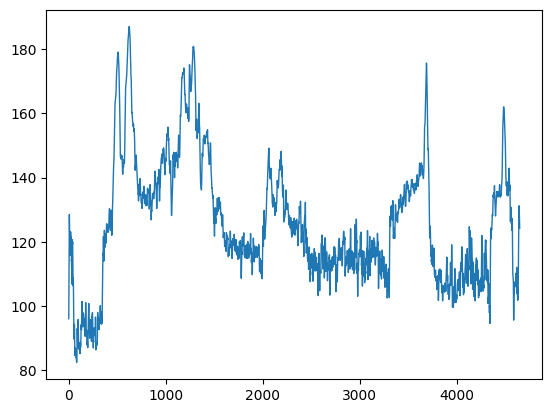

In [ ]:
r = sns.lineplot(x=np.arange(0, np.size(S7pred)), y=S7GT[:, 0], linewidth=1, legend=False)

# Nouvelle section

In [ ]:
import pickle
import matplotlib.pyplot as plt
import sys
import os
import json
import numpy as np
import copy

from sklearn.model_selection import LeaveOneGroupOut, GroupKFold
from sklearn.utils import shuffle

from scipy import signal

def obtain_MAE(dataset, fine=False):
    pred = '_pred' if not fine else '_pred_fine'
    label = '_label' if not fine else '_label_fine'
    MAE = []
    for pat in np.arange(1,16):
        dataset['P' +str(pat) +pred] = dataset['P' +str(pat) +pred]
        dataset['P' +str(pat) +label] = dataset['P' +str(pat) +label]
        MAE_pat = np.mean(np.abs(dataset['P' +str(pat) +label]-dataset['P' +str(pat) +pred]))
        MAE.append(MAE_pat)
    MAE = np.asarray(MAE)
    print('Mean-Pre: {}'.format(np.mean(MAE)))
    print('Median-Pre: {}'.format(np.median(MAE)))
    return MAE

def post_processing(dataset, fine=False):
    n = 10
    f_h = 10
    f_l = 10
    pred = '_pred' if not fine else '_pred_fine'
    label = '_label' if not fine else '_label_fine'
    MAE_postprocessing = []
    for pat in np.arange(1,16):
    	old_value = dataset['P' +str(pat) +pred][0]
    	for i in np.arange(n,len(dataset['P' +str(pat) +label])):
    		if np.mean(dataset['P' +str(pat) +pred][i]) > np.mean(dataset['P' +str(pat) +pred][(i-n):i])*(100+f_h)/100.0:
    		    dataset['P' +str(pat) +pred][i] = np.mean(dataset['P' +str(pat) +pred][(i-n):i])*(100+f_h)/100
    		if np.mean(dataset['P' +str(pat) +pred][i]) < np.mean(dataset['P' +str(pat) +pred][(i-n):i])*(100-f_l)/100.0:
    		    dataset['P' +str(pat) +pred][i] = np.mean(dataset['P' +str(pat) +pred][(i-n):i])*(100-f_l)/100
    	MAE_pat = np.mean(np.abs(dataset['P' +str(pat) +label]-dataset['P' +str(pat) +pred]))
    	MAE_postprocessing.append(MAE_pat)
    MAE_postprocessing = np.asarray(MAE_postprocessing)
    print('Mean-Post: {}'.format(np.mean(MAE_postprocessing)))
    print('Median-Post: {}'.format(np.median(MAE_postprocessing)))
    return MAE_postprocessing

path = '/content/drive/MyDrive/slimmed/saved_models_PIT/5.0e-07_1_data.pickle'
with open(path, 'rb') as f:
    dataset = pickle.load(f)

MAE = obtain_MAE(dataset, fine=False)
MAE_post = post_processing(dataset, fine=False)

Mean-Pre: 5.051735118561203
Median-Pre: 4.018176949249696
Mean-Post: 4.609760219962286
Median-Post: 3.6169149201858244


h5

# test

In [ ]:
import h5py

# Open the h5 file
file = h5py.File('/content/drive/MyDrive/slimmed/saved_models_PIT/test_reg15.h5', 'r')

# ['beta:0', 'gamma:0', 'moving_mean:0', 'moving_variance:0']>
file['model_weights'].keys()

#file.close()

<KeysViewHDF5 ['activation_165', 'activation_166', 'activation_167', 'activation_168', 'activation_169', 'activation_170', 'activation_171', 'activation_172', 'activation_173', 'activation_174', 'activation_175', 'average_pooling2d_45', 'average_pooling2d_46', 'average_pooling2d_47', 'batch_normalization_165', 'batch_normalization_166', 'batch_normalization_167', 'batch_normalization_168', 'batch_normalization_169', 'batch_normalization_170', 'batch_normalization_171', 'batch_normalization_172', 'batch_normalization_173', 'batch_normalization_174', 'batch_normalization_175', 'conv2d_107', 'conv2d_108', 'conv2d_109', 'conv2d_110', 'conv2d_111', 'conv2d_112', 'conv2d_113', 'conv2d_114', 'conv2d_115', 'dense_45', 'dense_46', 'dense_47', 'flatten_15', 'top_level_model_weights', 'zero_padding2d_33', 'zero_padding2d_34', 'zero_padding2d_35']>

In [ ]:
data

NameError: ignored

In [ ]:
# Access the original group
original_group = file['original_group_name']

# Create a new group with the desired name
new_group = file.create_group('new_group_name')

# Copy the contents of the original group to the new group
original_group.copy(new_group)

# Delete the original group
del file['original_group_name']

# Close the HDF5 file
h5_file.close()

KeyError: ignored

In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras import backend
import math

In [ ]:
width_mult = 1
in_shape = 256

dil_ht = False
dilLIST = [1, 2, 4, 4, 4, 4, 2]
#dilLIST = [1, 1, 1, 1, 1, 1, 1]
ofMAP = [32, 32, 63, 64, 62, 120, 59, 27, 28, 38, 51, 1]
n_ch=4

In [ ]:
dil_list = dilLIST
ofmap = ofMAP

rf = [5, 9, 17]

if not dil_list and dil_ht:
    dil_list = [
                2, 2, 1,
                4, 4,
                8, 8
                ]
elif not dil_list:
    dil_list = [
                1, 1, 1,
                1, 1,
                1, 1
                ]


if not ofmap:
    ofmap = [
            32, 32, 64,
            64, 64, 128,
            128, 128, 128,
            256, 128, 1
            ]
else:
    for idx, i in enumerate(ofmap):
        if i == 0:
            ofmap[idx] = 1


input_channel = width_mult * 32
output_channel = input_channel * 2

backend.clear_session()

model = Sequential()

model.add(layers.Conv2D(
    filters=ofmap[0],
    kernel_size=(1,math.ceil(rf[0]/dil_list[0])),
    padding='same', dilation_rate=(1,dil_list[0]),
    input_shape = (1, in_shape, n_ch)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(
    filters=ofmap[1],
    kernel_size=(1,math.ceil(rf[0]/dil_list[1])),
    padding='same', dilation_rate=(1,dil_list[1]),
    input_shape = (1, in_shape, 32)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

model.add(layers.ZeroPadding2D(padding=((0, 0), (4, 0))))
model.add(layers.Conv2D(
    filters=ofmap[2],
    kernel_size=(1,math.ceil(rf[0]/dil_list[2])),
    padding='valid', dilation_rate=(1,dil_list[2]),
    input_shape = (1, in_shape+4, 32)))
model.add(layers.AveragePooling2D(pool_size=(1,2), strides=2, padding='valid'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

input_channel = width_mult * 64
output_channel = input_channel*2

model.add(layers.Conv2D(
    filters=ofmap[3],
    kernel_size=(1,math.ceil(rf[1]/dil_list[3])),
    padding='same', dilation_rate=(1,dil_list[3]),
    input_shape = (1, in_shape/2 + 8, 64)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(
    filters=ofmap[4],
    kernel_size=(1,math.ceil(rf[1]/dil_list[4])),
    padding='same', dilation_rate=(1,dil_list[4]),
    input_shape = (1, in_shape/2 + 8, 64)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

model.add(layers.ZeroPadding2D(padding=((0, 0), (4, 0))))
model.add(layers.Conv2D(
    filters=ofmap[5],
    kernel_size=(1,5), padding='valid',
    strides=2, input_shape = (1, in_shape/2 + 4, 64)))
model.add(layers.AveragePooling2D(pool_size=(1,2), strides=2, padding='valid'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

input_channel = width_mult * 128
output_channel = input_channel*2

model.add(layers.Conv2D(
    filters=ofmap[6],
    kernel_size=(1,math.ceil(rf[2]/dil_list[5])),
    padding='same', dilation_rate=(1,dil_list[5]),
    input_shape = (1, in_shape/8 + 16, 128)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(
    filters=ofmap[7],
    kernel_size=(1,math.ceil(rf[2]/dil_list[6])),
    padding='same', dilation_rate=(1,dil_list[6]),
    input_shape = (1, in_shape/8 + 16, 128)))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

model.add(layers.ZeroPadding2D(padding=((0, 0), (5, 0))))
model.add(layers.Conv2D(
    filters=ofmap[8],
    kernel_size=(1,5), padding='valid',
    strides=4, input_shape = (1, in_shape/8 + 5, 128)))
model.add(layers.AveragePooling2D(pool_size=(1,2), strides=2, padding='valid'))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dense(ofmap[9]))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(ofmap[10]))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())

model.add(layers.Dense(ofmap[11]))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1, 256, 32)        672       
                                                                 
 activation (Activation)     (None, 1, 256, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 1, 256, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 256, 32)        3104      
                                                                 
 activation_1 (Activation)   (None, 1, 256, 32)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 256, 32)       128       
 hNormalization)                                        

In [ ]:
model.load_weights('/content/drive/MyDrive/slimmed/saved_models_PIT/test_reg9.h5')

In [ ]:
from preprocessing import preprocessing_Dalia as pp
from config import Config


In [ ]:
# Load data
import pickle

with open('/content/drive/MyDrive/slimmed/slimmed_dalia.pkl', 'rb') as f:
            data = pickle.load(f, encoding='latin1')

            ppg_acc = data['X']
            GT = data['y']
            activity = data['act']

print("dimension ppg_acc",ppg_acc.shape, "dimesion GT", GT.shape)

dimension ppg_acc (64697, 4, 256) dimesion GT (64697, 1)


In [ ]:
import numpy as np
input1 = np.moveaxis(ppg_acc, 1, 2)
input11=input1[0:1, :, :]
input_data = np.reshape(input1, (-1, 64697, 256, 4))
input_data = np.moveaxis(input_data, 0, 1)
input_data.shape

(64697, 1, 256, 4)

In [ ]:
predictions = model.predict(input_data)

2022/2022 [==============================] - 72s 36ms/step


In [ ]:
predictions

array([[84.05625 ],
       [90.39345 ],
       [85.88631 ],
       ...,
       [85.97716 ],
       [87.631294],
       [90.33165 ]], dtype=float32)

In [ ]:
GT

array([[51.78977214],
       [53.95587357],
       [59.37907894],
       ...,
       [84.90326124],
       [85.25177586],
       [85.70933822]])

S1= 3.18
S2= 1.78
S3= 1.91
S4= 1.61
S5= 2.20
S6=
S7=
S8=
S9=
S10=
S11=
S12=
S13=
S14=
S15=

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(predictions[4603+4099+4367+4572+4649+2622+4668+4037:4099+4603+4367+4572+4649+2622+4668+4037+4277], GT[4603+4099+4367+4572+4649+2622+4668+4037:4603+4099+4367+4572+4649+2622+4668+4037+4277])

3.2765108995577843

In [ ]:
import seaborn as sns

r = sns.lineplot(x=np.arange(0, np.size(S7pred)), y=S7GT[:, 0], linewidth=1, legend=False)

# Plot lambdas

In [ ]:
import numpy as np

MN_params = np.sort([138938, 285387, 15243, 80509])
MN_params

array([ 15243,  80509, 138938, 285387])

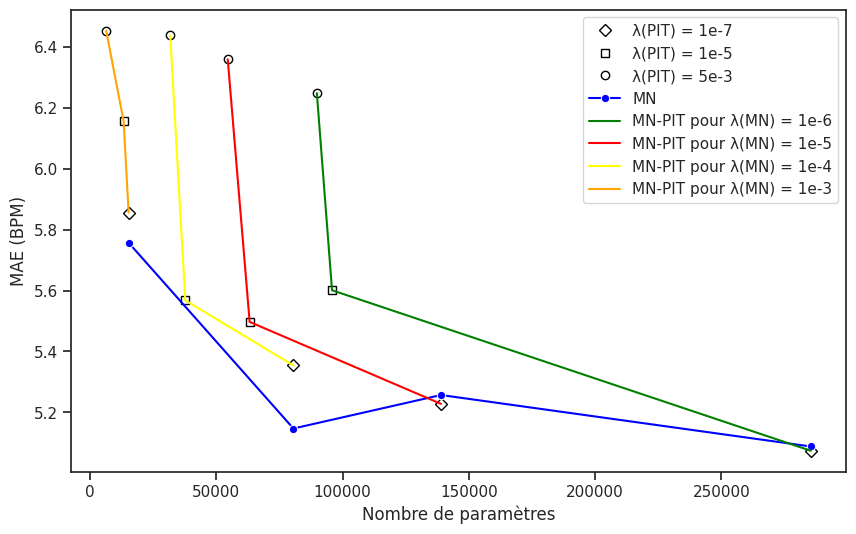

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Sample data for the line plots
MN_params = [285387, 138938, 80509, 15243]
MN_MAE = [5.088, 5.257, 5.147, 5.757]

PIT_params_mn6 = [285387, 95797, 89788]
PIT_params_mn5 = [138938, 63170, 54498]
PIT_params_mn4 = [80509, 37679, 31717]
PIT_params_mn3 = [15243, 13263, 6375]

PIT_MAE_mn6 = [5.074, 5.601, 6.248]
PIT_MAE_mn5 = [5.228, 5.497, 6.359]
PIT_MAE_mn4 = [5.354, 5.568, 6.438]
PIT_MAE_mn3 = [5.856, 6.156, 6.453]

df_MN = pd.DataFrame({'MN_params': MN_params, 'MN_MAE': MN_MAE})
df_MN = df_MN.sort_values('MN_params')

df_PIT_mn6 = pd.DataFrame({'PIT_params_mn6': PIT_params_mn6, 'PIT_MAE_mn6': PIT_MAE_mn6})
df_PIT_mn6 = df_PIT_mn6.sort_values('PIT_params_mn6')

df_PIT_mn5 = pd.DataFrame({'PIT_params_mn5': PIT_params_mn5, 'PIT_MAE_mn5': PIT_MAE_mn5})
df_PIT_mn5 = df_PIT_mn5.sort_values('PIT_params_mn5')

df_PIT_mn4 = pd.DataFrame({'PIT_params_mn4': PIT_params_mn4, 'PIT_MAE_mn4': PIT_MAE_mn4})
df_PIT_mn4 = df_PIT_mn4.sort_values('PIT_params_mn4')

df_PIT_mn3 = pd.DataFrame({'PIT_params_mn3': PIT_params_mn3, 'PIT_MAE_mn3': PIT_MAE_mn3})
df_PIT_mn3 = df_PIT_mn3.sort_values('PIT_params_mn3')



scat_x_1 = [285387, 138938,80509,15243]
scat_x_2 = [95797, 63170,37679,13263]
scat_x_3 = [89788, 54498,31717,6375]

scat_y_1 = [5.074, 5.228,5.354,5.856]
scat_y_2 = [5.601,  5.497, 5.568, 6.156]
scat_y_3 = [6.248,6.359,6.438,6.453]




# Set the style
sns.set_style("darkgrid")

# Create the plot

markerz = ['square', 'triangle-up', 'triangle-down']

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set(font_scale = 1)
with sns.axes_style("ticks"):

  #r = sns.scatterplot(x=scat_x_1, y=scat_y_1, color='blue')



  # Get the current axes object
  ax = plt.gca()

  # Iterate over each data point and plot non-filled markers with contour
  for xi, yi in zip(scat_x_1[0:3], scat_y_1[0:3]):
      ax.plot(xi, yi, marker='D', markersize=6, color='none', markeredgecolor='black')

  ax.plot(scat_x_1[3],scat_y_1[3], marker='D', markersize=6, color='none', markeredgecolor='black', label = 'λ(PIT) = 1e-7')

  for xi, yi in zip(scat_x_2[0:3], scat_y_2[0:3]):
      ax.plot(xi, yi, marker='s', markersize=6, color='none', markeredgecolor='black')

  ax.plot(scat_x_2[3],scat_y_2[3], marker='s', markersize=6, color='none', markeredgecolor='black', label = 'λ(PIT) = 1e-5')

  for xi, yi in zip(scat_x_3[0:3], scat_y_3[0:3]):
      ax.plot(xi, yi, marker='o', markersize=6, color='none', markeredgecolor='black')

  ax.plot(scat_x_3[3],scat_y_3[3], marker='o', markersize=6, color='none', markeredgecolor='black', label = 'λ(PIT) = 5e-3')



  plt.legend()





  r =sns.lineplot(x='MN_params', y='MN_MAE', data=df_MN, color='blue', marker='o', markersize=6, label='MN')
  r =sns.lineplot(x='PIT_params_mn6', y='PIT_MAE_mn6', data=df_PIT_mn6, color='green', markers=markerz, markersize=6, label='MN-PIT pour λ(MN) = 1e-6')
  r =sns.lineplot(x='PIT_params_mn5', y='PIT_MAE_mn5', data=df_PIT_mn5, color='red', markers=markerz, markersize=6, label='MN-PIT pour λ(MN) = 1e-5')
  r =sns.lineplot(x='PIT_params_mn4', y='PIT_MAE_mn4', data=df_PIT_mn4, color='yellow', markers=markerz, markersize=6, label='MN-PIT pour λ(MN) = 1e-4')
  r =sns.lineplot(x='PIT_params_mn3', y='PIT_MAE_mn3', data=df_PIT_mn3, color='orange', markers=markerz, markersize=6, label='MN-PIT pour λ(MN) = 1e-3')


# Set the plot title and labels
plt.xlabel('Nombre de paramètres')
plt.ylabel('MAE (BPM)')

# Show the legend
legend = plt.legend()
legend.get_frame().set_facecolor('w')

# Show the plot
plt.show()

In [ ]:
fig = r.get_figure()
fig.savefig("lmdaz.png", dpi=150)